In [1]:
import numpy as np 
from numpy import argmax

import tensorflow as tf
import itertools
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from keras.metrics import categorical_crossentropy

from itertools import chain


In [2]:
#Checking for tensorflow-GPU
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")


Default GPU Device: /device:GPU:0


In [3]:
#Unzipping Attack and Validation folders

# Unzip Attack Folder to retrive subfolfers
from zipfile import ZipFile
file_name = "Attack_Data_Master.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Unizipped Attack File')
    
# Unzip Validation Folder to retrive subfolfers
from zipfile import ZipFile
file_name = "Validation_Data_Master.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Unizipped Validation File')
    
# Unzip Training Folder to retrive subfolfers
from zipfile import ZipFile
file_name = "Training_Data_Master.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Unizipped Training File')

# list holding normal training data
train_normal_data = [] 



from pathlib import Path 
# list that holds attack vectors
train_attack_data = []

# Set file path ot the folder for iterations
input_dir = Path.cwd() / "Attack_Data_Master"
# store all the files ending with .txt in a list called files
files = list (input_dir.rglob("*.txt*"))
# Iterate over all the txt files and append the attack in the list train_attack data
for FILE in files:
  with open (FILE, 'r') as f:
    stringData = (f.read())
    string_split_data = stringData.split(" ")
    del (string_split_data[-1])
    train_attack_data.append(string_split_data)
    

for i in range(len(train_attack_data)):
  for j in range(len(train_attack_data[i])):
    train_attack_data[i][j] = int(train_attack_data[i][j])

from pathlib import Path 
# list that holds validation vectors
train_validation_data = []

# Set file path ot the folder for iterations
input_dir = Path.cwd() / "Validation_Data_Master"
# store all the files ending with .txt in a list called files
files = list (input_dir.rglob("*.txt*"))
# Iterate over all the txt files and append the attack in the list train_attack data
for FILE in files:
  with open (FILE, 'r') as f:
    stringData = (f.read())
    string_split_data = stringData.split(" ")
    del (string_split_data[-1])
    train_validation_data.append(string_split_data)
    

# list that holds training vectors
train_normal_data = []

# Set file path ot the folder for iterations
input_dir = Path.cwd() / "Training_Data_Master"
# store all the files ending with .txt in a list called files
files = list (input_dir.rglob("*.txt*"))
# Iterate over all the txt files and append the attack in the list train_attack data
for FILE in files:
  with open (FILE, 'r') as f:
    stringData = (f.read())
    string_split_data = stringData.split(" ")
    del (string_split_data[-1])
    train_normal_data.append(string_split_data)
    

for i in range(len(train_normal_data)):
  for j in range(len(train_normal_data[i])):
    train_normal_data[i][j] = int(train_normal_data[i][j])
print("Normal Data     --->  train_normal_data")
print("Attack Data     --->  train_attack_data")
print("Validation Data --->  train_validation_data")


Unizipped Attack File
Unizipped Validation File
Unizipped Training File
Normal Data     --->  train_normal_data
Attack Data     --->  train_attack_data
Validation Data --->  train_validation_data


In [4]:
#Statistics of the data

#Shortest request
shortest_seq = 1000;
#Longest request
longest_seq = 0;
#Average Request size in dataset
avg_seq = 0

sum = 0;
for i in range(len(train_normal_data)):
    curr_sequence_length = len(train_normal_data[i])
    if curr_sequence_length < shortest_seq:
        shortest_seq = curr_sequence_length
    if curr_sequence_length > longest_seq:
        longest_seq = curr_sequence_length
    sum += curr_sequence_length
avg_seq = int(sum/len(train_normal_data))

print(f"Shortest Request Length is {shortest_seq}")
print(f"Longest Request Length is {longest_seq}")
print(f"Average Request Length is {avg_seq}")
    

Shortest Request Length is 79
Longest Request Length is 2948
Average Request Length is 369


In [15]:
#Number of unique system calls in the normal list
unique_normal = []
# System calls that are present in the attack list but not in normal
attack_not_in_normal = []

#Appending unique system calls from the normal list
for i in range(len(train_normal_data)):
    for j in range(len(train_normal_data[i])):
        curr_sys_call = train_normal_data[i][j]
        if curr_sys_call in unique_normal:
            continue
        else:
            unique_normal.append(curr_sys_call)

#Appending unique system calls from the attack list that are not present in normal
for i in range(len(train_attack_data)):
    for j in range(len(train_attack_data[i])):
        curr_sys_call = train_attack_data[i][j]
        if curr_sys_call not in unique_normal:
            attack_not_in_normal.append(curr_sys_call)

In [6]:
# Unique system calls in normal list
len(unique_normal)

150

In [7]:
# Unique system calls in attack list not present in normal
attack_not_in_normal

[324, 324, 324, 324, 324, 324, 324, 173, 156]

In [8]:
#Generating one hot vectors
dict = {}
vocab_size = 341

for x in range(vocab_size):
    arr=[]
    arr = [0 for i in range(vocab_size)] 
    arr[x] = 1
    dict[x] = arr

In [17]:
#Sequence size
n = 15
#N-Gram
m = 2

In [18]:
# This method receives a request array and returns one hot encoded version of that array
def generate_one_hot(request):
    temp = []
    for sys_call in request:
        temp.append(dict[sys_call])
    return temp

# This method recevies a request array, start and  end of the request and populates x_train and y_train
# with returned one hot version from the generate_trainSet method
def split_request(source, target, request, start, end):
    while(len(request)-start >= n+m):
        source.append(generate_one_hot(request[start:end]))
        start += m
        end += m
        target.append(generate_one_hot(request[start:end]))
    

In [19]:
x_train = []
y_train = [] 

# Populating x_train and y_train with sources and targets
for i in range(len(train_normal_data)):
    split_request(x_train, y_train, train_normal_data[i],0,n)

In [20]:
print(len(x_train))
print(len(train_normal_data))


147595
833


In [21]:
# Converting x_train and y_train into np arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

In [22]:
#x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape)

(147595, 15, 341)


In [24]:
# split test data into training and testing sets
x_train, x_test,y_train,y_test = train_test_split(x_train,y_train,test_size=0.2,random_state=4)

In [25]:
n_timesteps = n
n_features = vocab_size
numberOfUnits = 200

input= Input(shape=(n_timesteps, n_features))

lstm1 = LSTM(numberOfUnits,return_sequences=True, return_state=True)
all_state_h, state_h, state_c = lstm1(input) 
states = [state_h, state_c]

lstm2 = LSTM(numberOfUnits,return_sequences=True)
all_state_h = lstm2(all_state_h,initial_state=states)

dense = (Dense(n_features, activation='softmax'))
output = dense(all_state_h)
model_LSTM_return_sequences_return_state = Model(input,output,
                                name='model_LSTM_all_state_h_return_state')
model_LSTM_return_sequences_return_state.compile(loss='categorical_crossentropy', 
                                                 optimizer='adam',
                                                 metrics=['accuracy'])
model_LSTM_return_sequences_return_state.summary()

Model: "model_LSTM_all_state_h_return_state"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15, 341)]    0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 15, 200),    433600      ['input_1[0][0]']                
                                 (None, 200),                                                     
                                 (None, 200)]                                                     
                                                                                                  
 lstm_1 (LSTM)                  (None, 15, 200)      320800      ['lstm[0][0]',                   
                                                                

In [28]:
def train_test(model, X_train, y_train , 
               X_test, 	y_test, epochs=50, 
							        verbose=0, patience=5):
	# patient early stopping
	#es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1, patience=20)
	es = EarlyStopping(monitor='val_loss', mode='min', 
	                   verbose=1, patience=patience)
	# train model
	print('training for ',epochs,
	      ' epochs begins with',
				' EarlyStopping(monitor= val_loss ',
				' patience=',patience,')....')
	history=model.fit(X_train, y_train, validation_split= 0.1, epochs=epochs,  verbose=verbose, callbacks=[es])
	print(epochs,' epoch training finished...')

	# report training
	# list all data in history
	print(history.history.keys())
	# evaluate the model
	_, train_acc = model.evaluate(X_train, y_train, verbose=0)
	_, test_acc = model.evaluate(X_test, 	y_test, verbose=0)
	print('\nPREDICTION ACCURACY (%):')
	print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
	# summarize history for accuracy
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title(model.name+' accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
	# summarize history for loss
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title(model.name+' loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()

training for  50  epochs begins with  EarlyStopping(monitor= val_loss   patience= 5 )....
Epoch 18: early stopping
50  epoch training finished...
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

PREDICTION ACCURACY (%):
Train: 97.053, Test: 95.054


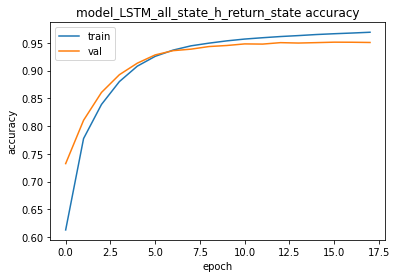

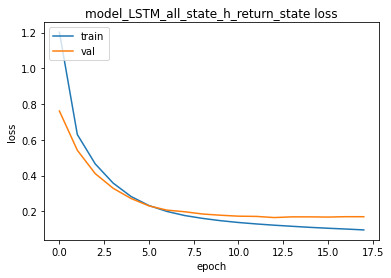

In [29]:
train_test(model_LSTM_return_sequences_return_state, x_train, y_train , x_test, y_test)

In [19]:
# import os.path
# if os.path.isfile('models/LSTM_HIDS.h5') is False:
#     model_LSTM_return_sequences_return_state.save('models/LSTM_HIDS.h5')

In [30]:
# Receives one hot represetation and returns index where value = 1
def one_hot_decode(arr):
    for index,num in enumerate(arr):
        if num == 1:
            return index
        
# Receives an array to append to and a 3D-array that is one hot encoded      
def decode(arr, three_d_array):
    for seq in three_d_array:
        temp = []
        for one_hot in seq:
            temp.append(one_hot_decode(one_hot))
        arr.append(temp)
    
        

In [31]:
# Decodes prediction done by LSTM and stores it in arr.
def prediction_decode(arr, prediction):
    for seq in prediction:
        predict_temp = []
        for one_hot in seq:
            predict_temp.append(argmax(one_hot))
        arr.append(predict_temp)
    
    

In [32]:
# Decoded vectors x_test and y_test
x_test_decoded = []
y_test_decoded = []
i = 1

#For simplicity, test number
test_number = 5000

while(i < test_number):
    decode(x_test_decoded,x_test[i-1:i])
    decode(y_test_decoded,y_test[i-1:i])
    i += 1

In [33]:
predictions = []
i = 1
while(i < test_number):
    prediction_decode(predictions, model_LSTM_return_sequences_return_state.predict(x_test[i-1:i]))
    print(i, "/", test_number)
    i += 1



1 / 5000
2 / 5000
3 / 5000
4 / 5000
5 / 5000
6 / 5000
7 / 5000
8 / 5000
9 / 5000
10 / 5000
11 / 5000
12 / 5000
13 / 5000
14 / 5000
15 / 5000
16 / 5000
17 / 5000
18 / 5000
19 / 5000
20 / 5000
21 / 5000
22 / 5000
23 / 5000
24 / 5000
25 / 5000
26 / 5000
27 / 5000
28 / 5000
29 / 5000
30 / 5000
31 / 5000
32 / 5000
33 / 5000
34 / 5000
35 / 5000
36 / 5000
37 / 5000
38 / 5000
39 / 5000
40 / 5000
41 / 5000
42 / 5000
43 / 5000
44 / 5000
45 / 5000
46 / 5000
47 / 5000
48 / 5000
49 / 5000
50 / 5000
51 / 5000
52 / 5000
53 / 5000
54 / 5000
55 / 5000
56 / 5000
57 / 5000
58 / 5000
59 / 5000
60 / 5000
61 / 5000
62 / 5000
63 / 5000
64 / 5000
65 / 5000
66 / 5000
67 / 5000
68 / 5000
69 / 5000
70 / 5000
71 / 5000
72 / 5000
73 / 5000
74 / 5000
75 / 5000
76 / 5000
77 / 5000
78 / 5000
79 / 5000
80 / 5000
81 / 5000
82 / 5000
83 / 5000
84 / 5000
85 / 5000
86 / 5000
87 / 5000
88 / 5000
89 / 5000
90 / 5000
91 / 5000
92 / 5000
93 / 5000
94 / 5000
95 / 5000
96 / 5000
97 / 5000
98 / 5000
99 / 5000
100 / 5000
101 / 50

759 / 5000
760 / 5000
761 / 5000
762 / 5000
763 / 5000
764 / 5000
765 / 5000
766 / 5000
767 / 5000
768 / 5000
769 / 5000
770 / 5000
771 / 5000
772 / 5000
773 / 5000
774 / 5000
775 / 5000
776 / 5000
777 / 5000
778 / 5000
779 / 5000
780 / 5000
781 / 5000
782 / 5000
783 / 5000
784 / 5000
785 / 5000
786 / 5000
787 / 5000
788 / 5000
789 / 5000
790 / 5000
791 / 5000
792 / 5000
793 / 5000
794 / 5000
795 / 5000
796 / 5000
797 / 5000
798 / 5000
799 / 5000
800 / 5000
801 / 5000
802 / 5000
803 / 5000
804 / 5000
805 / 5000
806 / 5000
807 / 5000
808 / 5000
809 / 5000
810 / 5000
811 / 5000
812 / 5000
813 / 5000
814 / 5000
815 / 5000
816 / 5000
817 / 5000
818 / 5000
819 / 5000
820 / 5000
821 / 5000
822 / 5000
823 / 5000
824 / 5000
825 / 5000
826 / 5000
827 / 5000
828 / 5000
829 / 5000
830 / 5000
831 / 5000
832 / 5000
833 / 5000
834 / 5000
835 / 5000
836 / 5000
837 / 5000
838 / 5000
839 / 5000
840 / 5000
841 / 5000
842 / 5000
843 / 5000
844 / 5000
845 / 5000
846 / 5000
847 / 5000
848 / 5000
849 / 5000

1463 / 5000
1464 / 5000
1465 / 5000
1466 / 5000
1467 / 5000
1468 / 5000
1469 / 5000
1470 / 5000
1471 / 5000
1472 / 5000
1473 / 5000
1474 / 5000
1475 / 5000
1476 / 5000
1477 / 5000
1478 / 5000
1479 / 5000
1480 / 5000
1481 / 5000
1482 / 5000
1483 / 5000
1484 / 5000
1485 / 5000
1486 / 5000
1487 / 5000
1488 / 5000
1489 / 5000
1490 / 5000
1491 / 5000
1492 / 5000
1493 / 5000
1494 / 5000
1495 / 5000
1496 / 5000
1497 / 5000
1498 / 5000
1499 / 5000
1500 / 5000
1501 / 5000
1502 / 5000
1503 / 5000
1504 / 5000
1505 / 5000
1506 / 5000
1507 / 5000
1508 / 5000
1509 / 5000
1510 / 5000
1511 / 5000
1512 / 5000
1513 / 5000
1514 / 5000
1515 / 5000
1516 / 5000
1517 / 5000
1518 / 5000
1519 / 5000
1520 / 5000
1521 / 5000
1522 / 5000
1523 / 5000
1524 / 5000
1525 / 5000
1526 / 5000
1527 / 5000
1528 / 5000
1529 / 5000
1530 / 5000
1531 / 5000
1532 / 5000
1533 / 5000
1534 / 5000
1535 / 5000
1536 / 5000
1537 / 5000
1538 / 5000
1539 / 5000
1540 / 5000
1541 / 5000
1542 / 5000
1543 / 5000
1544 / 5000
1545 / 5000
1546

2147 / 5000
2148 / 5000
2149 / 5000
2150 / 5000
2151 / 5000
2152 / 5000
2153 / 5000
2154 / 5000
2155 / 5000
2156 / 5000
2157 / 5000
2158 / 5000
2159 / 5000
2160 / 5000
2161 / 5000
2162 / 5000
2163 / 5000
2164 / 5000
2165 / 5000
2166 / 5000
2167 / 5000
2168 / 5000
2169 / 5000
2170 / 5000
2171 / 5000
2172 / 5000
2173 / 5000
2174 / 5000
2175 / 5000
2176 / 5000
2177 / 5000
2178 / 5000
2179 / 5000
2180 / 5000
2181 / 5000
2182 / 5000
2183 / 5000
2184 / 5000
2185 / 5000
2186 / 5000
2187 / 5000
2188 / 5000
2189 / 5000
2190 / 5000
2191 / 5000
2192 / 5000
2193 / 5000
2194 / 5000
2195 / 5000
2196 / 5000
2197 / 5000
2198 / 5000
2199 / 5000
2200 / 5000
2201 / 5000
2202 / 5000
2203 / 5000
2204 / 5000
2205 / 5000
2206 / 5000
2207 / 5000
2208 / 5000
2209 / 5000
2210 / 5000
2211 / 5000
2212 / 5000
2213 / 5000
2214 / 5000
2215 / 5000
2216 / 5000
2217 / 5000
2218 / 5000
2219 / 5000
2220 / 5000
2221 / 5000
2222 / 5000
2223 / 5000
2224 / 5000
2225 / 5000
2226 / 5000
2227 / 5000
2228 / 5000
2229 / 5000
2230

2834 / 5000
2835 / 5000
2836 / 5000
2837 / 5000
2838 / 5000
2839 / 5000
2840 / 5000
2841 / 5000
2842 / 5000
2843 / 5000
2844 / 5000
2845 / 5000
2846 / 5000
2847 / 5000
2848 / 5000
2849 / 5000
2850 / 5000
2851 / 5000
2852 / 5000
2853 / 5000
2854 / 5000
2855 / 5000
2856 / 5000
2857 / 5000
2858 / 5000
2859 / 5000
2860 / 5000
2861 / 5000
2862 / 5000
2863 / 5000
2864 / 5000
2865 / 5000
2866 / 5000
2867 / 5000
2868 / 5000
2869 / 5000
2870 / 5000
2871 / 5000
2872 / 5000
2873 / 5000
2874 / 5000
2875 / 5000
2876 / 5000
2877 / 5000
2878 / 5000
2879 / 5000
2880 / 5000
2881 / 5000
2882 / 5000
2883 / 5000
2884 / 5000
2885 / 5000
2886 / 5000
2887 / 5000
2888 / 5000
2889 / 5000
2890 / 5000
2891 / 5000
2892 / 5000
2893 / 5000
2894 / 5000
2895 / 5000
2896 / 5000
2897 / 5000
2898 / 5000
2899 / 5000
2900 / 5000
2901 / 5000
2902 / 5000
2903 / 5000
2904 / 5000
2905 / 5000
2906 / 5000
2907 / 5000
2908 / 5000
2909 / 5000
2910 / 5000
2911 / 5000
2912 / 5000
2913 / 5000
2914 / 5000
2915 / 5000
2916 / 5000
2917

3519 / 5000
3520 / 5000
3521 / 5000
3522 / 5000
3523 / 5000
3524 / 5000
3525 / 5000
3526 / 5000
3527 / 5000
3528 / 5000
3529 / 5000
3530 / 5000
3531 / 5000
3532 / 5000
3533 / 5000
3534 / 5000
3535 / 5000
3536 / 5000
3537 / 5000
3538 / 5000
3539 / 5000
3540 / 5000
3541 / 5000
3542 / 5000
3543 / 5000
3544 / 5000
3545 / 5000
3546 / 5000
3547 / 5000
3548 / 5000
3549 / 5000
3550 / 5000
3551 / 5000
3552 / 5000
3553 / 5000
3554 / 5000
3555 / 5000
3556 / 5000
3557 / 5000
3558 / 5000
3559 / 5000
3560 / 5000
3561 / 5000
3562 / 5000
3563 / 5000
3564 / 5000
3565 / 5000
3566 / 5000
3567 / 5000
3568 / 5000
3569 / 5000
3570 / 5000
3571 / 5000
3572 / 5000
3573 / 5000
3574 / 5000
3575 / 5000
3576 / 5000
3577 / 5000
3578 / 5000
3579 / 5000
3580 / 5000
3581 / 5000
3582 / 5000
3583 / 5000
3584 / 5000
3585 / 5000
3586 / 5000
3587 / 5000
3588 / 5000
3589 / 5000
3590 / 5000
3591 / 5000
3592 / 5000
3593 / 5000
3594 / 5000
3595 / 5000
3596 / 5000
3597 / 5000
3598 / 5000
3599 / 5000
3600 / 5000
3601 / 5000
3602

4206 / 5000
4207 / 5000
4208 / 5000
4209 / 5000
4210 / 5000
4211 / 5000
4212 / 5000
4213 / 5000
4214 / 5000
4215 / 5000
4216 / 5000
4217 / 5000
4218 / 5000
4219 / 5000
4220 / 5000
4221 / 5000
4222 / 5000
4223 / 5000
4224 / 5000
4225 / 5000
4226 / 5000
4227 / 5000
4228 / 5000
4229 / 5000
4230 / 5000
4231 / 5000
4232 / 5000
4233 / 5000
4234 / 5000
4235 / 5000
4236 / 5000
4237 / 5000
4238 / 5000
4239 / 5000
4240 / 5000
4241 / 5000
4242 / 5000
4243 / 5000
4244 / 5000
4245 / 5000
4246 / 5000
4247 / 5000
4248 / 5000
4249 / 5000
4250 / 5000
4251 / 5000
4252 / 5000
4253 / 5000
4254 / 5000
4255 / 5000
4256 / 5000
4257 / 5000
4258 / 5000
4259 / 5000
4260 / 5000
4261 / 5000
4262 / 5000
4263 / 5000
4264 / 5000
4265 / 5000
4266 / 5000
4267 / 5000
4268 / 5000
4269 / 5000
4270 / 5000
4271 / 5000
4272 / 5000
4273 / 5000
4274 / 5000
4275 / 5000
4276 / 5000
4277 / 5000
4278 / 5000
4279 / 5000
4280 / 5000
4281 / 5000
4282 / 5000
4283 / 5000
4284 / 5000
4285 / 5000
4286 / 5000
4287 / 5000
4288 / 5000
4289

4890 / 5000
4891 / 5000
4892 / 5000
4893 / 5000
4894 / 5000
4895 / 5000
4896 / 5000
4897 / 5000
4898 / 5000
4899 / 5000
4900 / 5000
4901 / 5000
4902 / 5000
4903 / 5000
4904 / 5000
4905 / 5000
4906 / 5000
4907 / 5000
4908 / 5000
4909 / 5000
4910 / 5000
4911 / 5000
4912 / 5000
4913 / 5000
4914 / 5000
4915 / 5000
4916 / 5000
4917 / 5000
4918 / 5000
4919 / 5000
4920 / 5000
4921 / 5000
4922 / 5000
4923 / 5000
4924 / 5000
4925 / 5000
4926 / 5000
4927 / 5000
4928 / 5000
4929 / 5000
4930 / 5000
4931 / 5000
4932 / 5000
4933 / 5000
4934 / 5000
4935 / 5000
4936 / 5000
4937 / 5000
4938 / 5000
4939 / 5000
4940 / 5000
4941 / 5000
4942 / 5000
4943 / 5000
4944 / 5000
4945 / 5000
4946 / 5000
4947 / 5000
4948 / 5000
4949 / 5000
4950 / 5000
4951 / 5000
4952 / 5000
4953 / 5000
4954 / 5000
4955 / 5000
4956 / 5000
4957 / 5000
4958 / 5000
4959 / 5000
4960 / 5000
4961 / 5000
4962 / 5000
4963 / 5000
4964 / 5000
4965 / 5000
4966 / 5000
4967 / 5000
4968 / 5000
4969 / 5000
4970 / 5000
4971 / 5000
4972 / 5000
4973

In [34]:
for i in range(len(predictions)):
    print("Source:    ", x_test_decoded[i])
    print("Target:    ", y_test_decoded[i])
    print("Prediction:", predictions[i]) 
    print("--------------------------------------------------------------------------------------------------")

Source:     [78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78]
Target:     [78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78]
Prediction: [78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78]
--------------------------------------------------------------------------------------------------
Source:     [78, 180, 180, 180, 91, 78, 180, 78, 180, 180, 180, 180, 180, 180, 180]
Target:     [180, 180, 91, 78, 180, 78, 180, 180, 180, 180, 180, 180, 180, 180, 180]
Prediction: [180, 180, 91, 78, 180, 78, 180, 180, 180, 180, 180, 180, 180, 180, 180]
--------------------------------------------------------------------------------------------------
Source:     [265, 240, 240, 196, 78, 240, 265, 240, 240, 196, 78, 265, 240, 240, 196]
Target:     [240, 196, 78, 240, 265, 240, 240, 196, 78, 265, 240, 240, 196, 78, 265]
Prediction: [240, 196, 78, 240, 265, 240, 240, 196, 78, 265, 240, 240, 196, 78, 265]
-------------------------------------------------------------------------

Source:     [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Target:     [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Prediction: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
--------------------------------------------------------------------------------------------------
Source:     [3, 168, 168, 3, 146, 168, 146, 146, 3, 3, 168, 3, 168, 168, 3]
Target:     [168, 3, 146, 168, 146, 146, 3, 3, 168, 3, 168, 168, 3, 3, 168]
Prediction: [168, 3, 146, 168, 146, 146, 3, 3, 168, 3, 168, 168, 3, 3, 3]
--------------------------------------------------------------------------------------------------
Source:     [33, 33, 78, 4, 5, 197, 192, 6, 91, 78, 4, 5, 197, 192, 6]
Target:     [78, 4, 5, 197, 192, 6, 91, 78, 4, 5, 197, 192, 6, 33, 5]
Prediction: [78, 4, 5, 197, 192, 6, 91, 78, 4, 5, 197, 192, 6, 33, 5]
--------------------------------------------------------------------------------------------------
Source:     [6, 5, 5, 5, 5, 91, 195, 5, 221, 197, 192, 6, 5, 5, 5]
Target:     [5, 5, 5, 91,

Target:     [6, 6, 6, 6, 195, 5, 6, 6, 195, 6, 201, 199, 202, 200, 3]
Prediction: [6, 6, 6, 6, 195, 5, 6, 6, 195, 6, 201, 199, 202, 200, 196]
--------------------------------------------------------------------------------------------------
Source:     [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4]
Target:     [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 3, 4]
Prediction: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4]
--------------------------------------------------------------------------------------------------
Source:     [4, 240, 5, 221, 78, 5, 6, 9, 195, 10, 33, 195, 33, 195, 33]
Target:     [5, 221, 78, 5, 6, 9, 195, 10, 33, 195, 33, 195, 33, 195, 33]
Prediction: [5, 221, 78, 5, 6, 9, 195, 10, 33, 195, 33, 195, 33, 195, 33]
--------------------------------------------------------------------------------------------------
Source:     [240, 240, 196, 78, 265, 240, 240, 240, 196, 78, 265, 240, 240, 240, 196]
Target:     [196, 78, 265, 240, 240, 240, 196, 78, 265, 240, 240, 240, 196, 78, 

Source:     [195, 195, 5, 5, 5, 197, 5, 197, 192, 3, 197, 45, 3, 3, 3]
Target:     [5, 5, 5, 197, 5, 197, 192, 3, 197, 45, 3, 3, 3, 6, 91]
Prediction: [5, 5, 5, 197, 5, 197, 192, 3, 197, 45, 3, 3, 3, 6, 91]
--------------------------------------------------------------------------------------------------
Source:     [102, 13, 102, 102, 102, 102, 6, 195, 5, 197, 192, 3, 3, 6, 91]
Target:     [102, 102, 102, 102, 6, 195, 5, 197, 192, 3, 3, 6, 91, 195, 102]
Prediction: [102, 102, 102, 102, 6, 195, 5, 197, 192, 3, 3, 6, 91, 195, 102]
--------------------------------------------------------------------------------------------------
Source:     [195, 5, 221, 197, 45, 45, 91, 195, 5, 45, 45, 45, 91, 195, 5]
Target:     [221, 197, 45, 45, 91, 195, 5, 45, 45, 45, 91, 195, 5, 221, 197]
Prediction: [221, 197, 45, 45, 91, 195, 5, 45, 45, 45, 91, 195, 5, 221, 197]
--------------------------------------------------------------------------------------------------
Source:     [140, 4, 265, 221, 221, 2

Prediction: [3, 3, 3, 3, 45, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
--------------------------------------------------------------------------------------------------
Source:     [85, 195, 3, 6, 85, 195, 196, 85, 195, 196, 5, 3, 6, 85, 195]
Target:     [3, 6, 85, 195, 196, 85, 195, 196, 5, 3, 6, 85, 195, 196, 5]
Prediction: [3, 6, 85, 195, 196, 85, 195, 196, 5, 3, 6, 85, 195, 195, 196]
--------------------------------------------------------------------------------------------------
Source:     [78, 78, 5, 196, 78, 78, 5, 196, 195, 85, 78, 196, 196, 196, 196]
Target:     [5, 196, 78, 78, 5, 196, 195, 85, 78, 196, 196, 196, 196, 196, 196]
Prediction: [5, 196, 78, 78, 5, 196, 195, 85, 78, 196, 196, 196, 196, 196, 196]
--------------------------------------------------------------------------------------------------
Source:     [265, 4, 4, 265, 265, 78, 265, 265, 4, 4, 265, 265, 265, 4, 6]
Target:     [4, 265, 265, 78, 265, 265, 4, 4, 265, 265, 265, 4, 6, 265, 4]
Prediction: [4, 265, 265, 78, 265,

Target:     [4, 4, 4, 3, 3, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4]
Prediction: [4, 4, 4, 3, 3, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4]
--------------------------------------------------------------------------------------------------
Source:     [6, 5, 5, 5, 91, 195, 195, 195, 195, 195, 195, 195, 6, 5, 6]
Target:     [5, 5, 91, 195, 195, 195, 195, 195, 195, 195, 6, 5, 6, 5, 197]
Prediction: [5, 5, 91, 195, 195, 195, 195, 195, 195, 195, 6, 5, 6, 6, 195]
--------------------------------------------------------------------------------------------------
Source:     [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4]
Target:     [4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4]
Prediction: [4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4]
--------------------------------------------------------------------------------------------------
Source:     [4, 4, 4, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4]
Target:     [4, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 3, 4]
Prediction: [4, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4]
----------------

Prediction: [240, 240, 196, 240, 78, 240, 196, 240, 240, 240, 78, 265, 240, 240, 196]
--------------------------------------------------------------------------------------------------
Source:     [4, 265, 168, 3, 265, 265, 4, 265, 265, 168, 195, 4, 195, 4, 265]
Target:     [168, 3, 265, 265, 4, 265, 265, 168, 195, 4, 195, 4, 265, 168, 4]
Prediction: [168, 3, 265, 265, 4, 265, 265, 168, 195, 4, 4, 195, 265, 265, 168]
--------------------------------------------------------------------------------------------------
Source:     [114, 5, 120, 6, 120, 114, 63, 42, 114, 114, 42, 120, 6, 42, 120]
Target:     [120, 6, 120, 114, 63, 42, 114, 114, 42, 120, 6, 42, 120, 6, 6]
Prediction: [120, 6, 120, 114, 63, 42, 114, 6, 42, 120, 6, 42, 120, 6, 114]
--------------------------------------------------------------------------------------------------
Source:     [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Target:     [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Prediction: [4, 4, 4, 4, 4, 4, 4, 4

Prediction: [195, 5, 197, 192, 3, 6, 91, 5, 197, 192, 3, 3, 6, 91, 195]
--------------------------------------------------------------------------------------------------
Source:     [255, 255, 255, 256, 265, 102, 255, 255, 256, 265, 3, 255, 255, 255, 265]
Target:     [255, 256, 265, 102, 255, 255, 256, 265, 3, 255, 255, 255, 265, 6, 6]
Prediction: [255, 256, 265, 102, 255, 255, 256, 265, 3, 255, 255, 255, 265, 6, 6]
--------------------------------------------------------------------------------------------------
Source:     [197, 42, 120, 6, 6, 3, 6, 54, 140, 197, 3, 174, 175, 174, 195]
Target:     [120, 6, 6, 3, 6, 54, 140, 197, 3, 174, 175, 174, 195, 5, 5]
Prediction: [120, 6, 6, 3, 6, 54, 140, 197, 3, 174, 174, 174, 195, 195, 6]
--------------------------------------------------------------------------------------------------
Source:     [63, 4, 63, 6, 3, 3, 221, 6, 221, 63, 4, 63, 6, 3, 3]
Target:     [63, 6, 3, 3, 221, 6, 221, 63, 4, 63, 6, 3, 3, 3, 63]
Prediction: [63, 6, 3, 3,

Target:     [175, 175, 175, 42, 175, 175, 175, 140, 120, 175, 174, 6, 3, 7, 175]
Prediction: [175, 175, 175, 42, 175, 175, 175, 140, 120, 175, 174, 6, 3, 7, 7]
--------------------------------------------------------------------------------------------------
Source:     [91, 5, 197, 192, 3, 3, 6, 91, 195, 5, 197, 192, 3, 6, 91]
Target:     [197, 192, 3, 3, 6, 91, 195, 5, 197, 192, 3, 6, 91, 5, 197]
Prediction: [197, 192, 3, 3, 6, 91, 195, 5, 197, 192, 3, 6, 91, 5, 197]
--------------------------------------------------------------------------------------------------
Source:     [4, 4, 3, 4, 3, 3, 4, 4, 4, 3, 4, 4, 4, 4, 3]
Target:     [3, 4, 3, 3, 4, 4, 4, 3, 4, 4, 4, 4, 3, 3, 4]
Prediction: [3, 4, 3, 3, 4, 4, 4, 3, 4, 4, 4, 4, 3, 4, 4]
--------------------------------------------------------------------------------------------------
Source:     [146, 146, 146, 168, 146, 168, 168, 146, 168, 146, 122, 168, 168, 122, 168]
Target:     [146, 168, 146, 168, 168, 146, 168, 146, 122, 168, 168

--------------------------------------------------------------------------------------------------
Source:     [91, 78, 91, 91, 91, 91, 5, 4, 6, 146, 6, 146, 6, 6, 6]
Target:     [91, 91, 91, 91, 5, 4, 6, 146, 6, 146, 6, 6, 6, 10, 6]
Prediction: [91, 91, 91, 91, 5, 4, 6, 146, 146, 6, 6, 6, 6, 6, 6]
--------------------------------------------------------------------------------------------------
Source:     [3, 197, 45, 195, 6, 3, 6, 3, 6, 195, 195, 195, 195, 195, 5]
Target:     [45, 195, 6, 3, 6, 3, 6, 195, 195, 195, 195, 195, 5, 3, 6]
Prediction: [45, 195, 6, 3, 6, 3, 6, 195, 195, 195, 195, 195, 5, 3, 3]
--------------------------------------------------------------------------------------------------
Source:     [33, 33, 33, 5, 125, 33, 33, 33, 33, 33, 3, 6, 3, 6, 33]
Target:     [33, 5, 125, 33, 33, 33, 33, 33, 3, 6, 3, 6, 33, 196, 5]
Prediction: [33, 5, 33, 33, 33, 33, 33, 33, 3, 6, 3, 6, 33, 33, 33]
---------------------------------------------------------------------------------

Source:     [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Target:     [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Prediction: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
--------------------------------------------------------------------------------------------------
Source:     [175, 175, 175, 45, 175, 175, 120, 175, 7, 175, 120, 175, 120, 175, 175]
Target:     [175, 45, 175, 175, 120, 175, 7, 175, 120, 175, 120, 175, 175, 120, 175]
Prediction: [175, 45, 175, 175, 120, 175, 7, 175, 120, 175, 120, 175, 175, 175, 175]
--------------------------------------------------------------------------------------------------
Source:     [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Target:     [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Prediction: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
--------------------------------------------------------------------------------------------------
Source:     [6, 91, 6, 54, 54, 54, 85, 196, 196, 196, 195, 5, 197, 192, 197]
Target:     [6, 54, 54,

Target:     [195, 195, 3, 6, 91, 5, 197, 197, 192, 3, 3, 195, 3, 6, 91]
Prediction: [195, 195, 3, 6, 91, 5, 197, 197, 192, 3, 3, 195, 3, 6, 91]
--------------------------------------------------------------------------------------------------
Source:     [33, 192, 6, 6, 6, 125, 125, 125, 91, 102, 102, 33, 168, 146, 168]
Target:     [6, 6, 6, 125, 125, 125, 91, 102, 102, 33, 168, 146, 168, 3, 146]
Prediction: [6, 6, 6, 125, 125, 125, 91, 102, 102, 102, 168, 146, 168, 168, 3]
--------------------------------------------------------------------------------------------------
Source:     [3, 6, 42, 3, 195, 195, 120, 6, 114, 42, 6, 6, 120, 114, 114]
Target:     [42, 3, 195, 195, 120, 6, 114, 42, 6, 6, 120, 114, 114, 5, 195]
Prediction: [42, 3, 195, 195, 120, 6, 114, 42, 6, 6, 120, 114, 114, 5, 221]
--------------------------------------------------------------------------------------------------
Source:     [78, 78, 5, 197, 3, 6, 78, 195, 78, 78, 78, 3, 265, 168, 4]
Target:     [5, 197, 3, 6

Prediction: [240, 196, 240, 78, 240, 196, 78, 265, 240, 240, 240, 196, 78, 265, 240]
--------------------------------------------------------------------------------------------------
Source:     [3, 6, 3, 3, 33, 33, 33, 33, 3, 42, 42, 120, 6, 6, 3]
Target:     [3, 3, 33, 33, 33, 33, 3, 42, 42, 120, 6, 6, 3, 5, 3]
Prediction: [3, 3, 33, 33, 33, 33, 3, 42, 42, 120, 6, 6, 3, 6, 54]
--------------------------------------------------------------------------------------------------
Source:     [91, 5, 197, 3, 3, 6, 195, 5, 197, 3, 3, 6, 195, 5, 197]
Target:     [197, 3, 3, 6, 195, 5, 197, 3, 3, 6, 195, 5, 197, 3, 3]
Prediction: [197, 3, 3, 6, 195, 5, 197, 3, 3, 6, 195, 5, 197, 3, 3]
--------------------------------------------------------------------------------------------------
Source:     [168, 146, 168, 146, 3, 3, 265, 3, 3, 265, 168, 146, 168, 3, 3]
Target:     [168, 146, 3, 3, 265, 3, 3, 265, 168, 146, 168, 3, 3, 265, 3]
Prediction: [168, 146, 3, 3, 265, 3, 3, 265, 168, 146, 168, 3, 3

Source:     [168, 4, 168, 42, 221, 221, 221, 221, 221, 221, 221, 221, 168, 102, 168]
Target:     [168, 42, 221, 221, 221, 221, 221, 221, 221, 221, 168, 102, 168, 102, 6]
Prediction: [168, 42, 221, 221, 221, 221, 221, 221, 221, 221, 168, 102, 168, 102, 6]
--------------------------------------------------------------------------------------------------
Source:     [180, 180, 125, 180, 125, 180, 125, 180, 180, 180, 180, 180, 180, 180, 180]
Target:     [125, 180, 125, 180, 125, 180, 180, 180, 180, 180, 180, 180, 180, 125, 125]
Prediction: [125, 180, 125, 180, 125, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180]
--------------------------------------------------------------------------------------------------
Source:     [175, 42, 175, 175, 175, 140, 120, 175, 174, 6, 3, 7, 175, 175, 45]
Target:     [175, 175, 175, 140, 120, 175, 174, 6, 3, 7, 175, 175, 45, 45, 45]
Prediction: [175, 175, 175, 140, 120, 175, 174, 6, 3, 7, 175, 175, 45, 175, 175]
-------------------------------------------

Prediction: [192, 192, 6, 33, 5, 3, 197, 192, 125, 192, 6, 33, 5, 3, 197]
--------------------------------------------------------------------------------------------------
Source:     [221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221]
Target:     [221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221]
Prediction: [221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221]
--------------------------------------------------------------------------------------------------
Source:     [265, 78, 78, 78, 265, 13, 3, 3, 195, 102, 168, 54, 102, 6, 265]
Target:     [78, 78, 265, 13, 3, 3, 195, 102, 168, 54, 102, 6, 265, 78, 4]
Prediction: [78, 78, 197, 13, 3, 3, 195, 102, 168, 54, 102, 6, 265, 78, 78]
--------------------------------------------------------------------------------------------------
Source:     [140, 140, 6, 3, 3, 3, 45, 3, 3, 45, 3, 3, 6, 221, 3]
Target:     [6, 3, 3, 3, 45, 3, 3, 45, 3, 3, 6, 221, 3, 3, 5]
Predictio

Source:     [5, 3, 197, 192, 192, 6, 33, 5, 3, 197, 192, 192, 6, 33, 5]
Target:     [197, 192, 192, 6, 33, 5, 3, 197, 192, 192, 6, 33, 5, 3, 197]
Prediction: [197, 192, 192, 6, 33, 5, 3, 197, 192, 192, 6, 33, 5, 3, 197]
--------------------------------------------------------------------------------------------------
Source:     [4, 78, 78, 265, 102, 168, 54, 102, 6, 265, 78, 78, 78, 265, 102]
Target:     [78, 265, 102, 168, 54, 102, 6, 265, 78, 78, 78, 265, 102, 91, 102]
Prediction: [78, 265, 102, 168, 54, 102, 6, 265, 78, 78, 78, 265, 102, 102, 102]
--------------------------------------------------------------------------------------------------
Source:     [78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78]
Target:     [78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78]
Prediction: [78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78]
--------------------------------------------------------------------------------------------------
Source:     [5, 221, 197,

--------------------------------------------------------------------------------------------------
Source:     [195, 195, 195, 195, 195, 195, 5, 197, 192, 197, 140, 221, 221, 13, 5]
Target:     [195, 195, 195, 195, 5, 197, 192, 197, 140, 221, 221, 13, 5, 197, 197]
Prediction: [195, 195, 195, 195, 5, 197, 192, 197, 140, 221, 221, 13, 5, 197, 197]
--------------------------------------------------------------------------------------------------
Source:     [125, 125, 91, 45, 45, 12, 5, 221, 141, 5, 197, 192, 3, 6, 91]
Target:     [91, 45, 45, 12, 5, 221, 141, 5, 197, 192, 3, 6, 91, 5, 197]
Prediction: [91, 45, 45, 12, 5, 221, 141, 5, 197, 192, 3, 6, 91, 5, 197]
--------------------------------------------------------------------------------------------------
Source:     [6, 6, 168, 4, 168, 42, 221, 221, 221, 221, 221, 221, 221, 221, 168]
Target:     [168, 4, 168, 42, 221, 221, 221, 221, 221, 221, 221, 221, 168, 102, 102]
Prediction: [168, 4, 168, 42, 221, 221, 221, 221, 221, 221, 221, 22

Source:     [102, 102, 13, 102, 102, 102, 102, 6, 195, 5, 197, 192, 3, 3, 6]
Target:     [13, 102, 102, 102, 102, 6, 195, 5, 197, 192, 3, 3, 6, 91, 195]
Prediction: [13, 102, 102, 102, 102, 6, 195, 5, 197, 192, 3, 3, 6, 91, 195]
--------------------------------------------------------------------------------------------------
Source:     [6, 91, 6, 6, 195, 5, 5, 5, 5, 195, 5, 5, 5, 197, 5]
Target:     [6, 6, 195, 5, 5, 5, 5, 195, 5, 5, 5, 197, 5, 197, 192]
Prediction: [6, 6, 195, 5, 5, 5, 5, 195, 5, 5, 5, 197, 5, 197, 192]
--------------------------------------------------------------------------------------------------
Source:     [175, 175, 175, 175, 175, 54, 175, 175, 175, 175, 175, 175, 307, 175, 175]
Target:     [175, 175, 175, 54, 175, 175, 175, 175, 175, 175, 307, 175, 175, 307, 175]
Prediction: [175, 175, 175, 54, 175, 175, 175, 175, 175, 175, 307, 175, 175, 175, 175]
--------------------------------------------------------------------------------------------------
Source:     

Target:     [5, 4, 197, 192, 3, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33]
Prediction: [5, 4, 197, 192, 3, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33]
--------------------------------------------------------------------------------------------------
Source:     [197, 6, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 197]
Target:     [6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 197, 3, 197]
Prediction: [6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 197, 3, 3]
--------------------------------------------------------------------------------------------------
Source:     [5, 3, 197, 192, 125, 192, 192, 6, 33, 5, 3, 197, 192, 192, 6]
Target:     [197, 192, 125, 192, 192, 6, 33, 5, 3, 197, 192, 192, 6, 33, 5]
Prediction: [197, 192, 125, 192, 192, 6, 33, 5, 3, 197, 192, 192, 6, 33, 5]
--------------------------------------------------------------------------------------------------
Source:     [6, 54, 140, 197, 3, 6, 174, 174, 174, 7, 174, 174, 174, 42, 42]
Target:     [140, 197, 3, 6, 174, 174, 174, 7, 174, 174, 174, 42, 42, 1

Source:     [192, 192, 6, 33, 5, 3, 197, 192, 192, 6, 33, 5, 3, 197, 192]
Target:     [6, 33, 5, 3, 197, 192, 192, 6, 33, 5, 3, 197, 192, 125, 192]
Prediction: [6, 33, 5, 3, 197, 192, 192, 6, 33, 5, 3, 197, 192, 192, 6]
--------------------------------------------------------------------------------------------------
Source:     [3, 195, 4, 221, 33, 195, 5, 196, 195, 4, 5, 192, 6, 196, 78]
Target:     [4, 221, 33, 195, 5, 196, 195, 4, 5, 192, 6, 196, 78, 91, 78]
Prediction: [4, 221, 33, 195, 5, 196, 195, 78, 5, 220, 6, 196, 78, 196, 78]
--------------------------------------------------------------------------------------------------
Source:     [196, 240, 78, 240, 196, 78, 240, 196, 78, 265, 240, 240, 196, 240, 78]
Target:     [78, 240, 196, 78, 240, 196, 78, 265, 240, 240, 196, 240, 78, 265, 240]
Prediction: [78, 240, 196, 78, 240, 196, 78, 265, 240, 240, 196, 240, 78, 240, 240]
--------------------------------------------------------------------------------------------------
Source:

Source:     [7, 7, 7, 3, 195, 42, 6, 5, 142, 7, 3, 4, 140, 140, 120]
Target:     [7, 3, 195, 42, 6, 5, 142, 7, 3, 4, 140, 140, 120, 3, 221]
Prediction: [7, 3, 195, 5, 6, 5, 142, 7, 3, 4, 140, 140, 120, 120, 6]
--------------------------------------------------------------------------------------------------
Source:     [197, 192, 6, 33, 5, 3, 197, 192, 192, 6, 33, 5, 3, 197, 192]
Target:     [6, 33, 5, 3, 197, 192, 192, 6, 33, 5, 3, 197, 192, 192, 6]
Prediction: [6, 33, 5, 3, 197, 192, 192, 6, 33, 5, 3, 197, 192, 192, 6]
--------------------------------------------------------------------------------------------------
Source:     [175, 5, 4, 175, 195, 307, 175, 45, 5, 221, 195, 175, 195, 175, 175]
Target:     [4, 175, 195, 307, 175, 45, 5, 221, 195, 175, 195, 175, 175, 5, 195]
Prediction: [4, 175, 195, 307, 175, 45, 5, 221, 195, 195, 175, 175, 175, 175, 175]
--------------------------------------------------------------------------------------------------
Source:     [78, 78, 78, 78, 7

Prediction: [220, 220, 5, 4, 5, 6, 197, 220, 220, 5, 5, 5, 5, 220, 5]
--------------------------------------------------------------------------------------------------
Source:     [265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265]
Target:     [265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265]
Prediction: [265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265]
--------------------------------------------------------------------------------------------------
Source:     [195, 5, 5, 5, 5, 195, 5, 5, 5, 5, 195, 5, 5, 5, 5]
Target:     [5, 5, 5, 195, 5, 5, 5, 5, 195, 5, 5, 5, 5, 195, 5]
Prediction: [5, 5, 5, 195, 5, 5, 5, 5, 195, 5, 5, 5, 5, 195, 5]
--------------------------------------------------------------------------------------------------
Source:     [6, 5, 6, 3, 6, 5, 3, 45, 6, 5, 197, 3, 6, 5, 5]
Target:     [6, 3, 6, 5, 3, 45, 6, 5, 197, 3, 6, 5, 5, 6, 5]
Prediction: [6, 3, 6, 5, 3, 45, 6, 5, 197, 3, 6, 5, 5, 

--------------------------------------------------------------------------------------------------
Source:     [42, 42, 120, 6, 6, 3, 6, 54, 140, 240, 42, 120, 6, 174, 174]
Target:     [120, 6, 6, 3, 6, 54, 140, 240, 42, 120, 6, 174, 174, 3, 6]
Prediction: [120, 6, 6, 3, 6, 54, 140, 174, 42, 120, 6, 174, 174, 174, 195]
--------------------------------------------------------------------------------------------------
Source:     [240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240]
Target:     [240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240]
Prediction: [240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240]
--------------------------------------------------------------------------------------------------
Source:     [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
Target:     [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
Prediction: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
-------------------------------------------

Source:     [5, 3, 3, 5, 3, 3, 174, 102, 221, 201, 168, 240, 240, 160, 125]
Target:     [3, 5, 3, 3, 174, 102, 221, 201, 168, 240, 240, 160, 125, 160, 125]
Prediction: [3, 5, 3, 3, 174, 201, 221, 201, 221, 240, 159, 125, 240, 240, 240]
--------------------------------------------------------------------------------------------------
Source:     [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Target:     [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Prediction: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
--------------------------------------------------------------------------------------------------
Source:     [4, 3, 4, 4, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 3]
Target:     [4, 4, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 3, 4, 3]
Prediction: [4, 4, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 3, 3, 3]
--------------------------------------------------------------------------------------------------
Source:     [265, 240, 240, 240, 196, 78, 265, 240, 240, 240, 196, 78, 265, 240, 240]
Target:     [240, 240, 196, 78, 2

Prediction: [33, 33, 3, 33, 146, 3, 122, 168, 146, 168, 3, 3, 3, 146, 146]
--------------------------------------------------------------------------------------------------
Source:     [6, 33, 5, 3, 197, 192, 192, 6, 33, 5, 3, 197, 192, 192, 192]
Target:     [5, 3, 197, 192, 192, 6, 33, 5, 3, 197, 192, 192, 192, 6, 125]
Prediction: [5, 3, 197, 192, 192, 6, 33, 5, 3, 197, 192, 192, 192, 6, 33]
--------------------------------------------------------------------------------------------------
Source:     [174, 42, 42, 120, 6, 6, 3, 6, 54, 140, 197, 3, 3, 197, 6]
Target:     [42, 120, 6, 6, 3, 6, 54, 140, 197, 3, 3, 197, 6, 174, 174]
Prediction: [42, 120, 6, 6, 3, 6, 54, 140, 197, 3, 3, 197, 6, 174, 174]
--------------------------------------------------------------------------------------------------
Source:     [102, 221, 221, 201, 102, 174, 168, 102, 102, 168, 3, 168, 102, 168, 3]
Target:     [221, 201, 102, 174, 168, 102, 102, 168, 3, 168, 102, 168, 3, 168, 102]
Prediction: [221, 201,

Source:     [240, 240, 196, 78, 265, 240, 240, 240, 196, 78, 265, 240, 240, 240, 196]
Target:     [196, 78, 265, 240, 240, 240, 196, 78, 265, 240, 240, 240, 196, 78, 265]
Prediction: [196, 78, 265, 240, 240, 240, 196, 78, 265, 240, 240, 240, 196, 78, 265]
--------------------------------------------------------------------------------------------------
Source:     [5, 3, 3, 6, 195, 5, 3, 45, 45, 140, 3, 140, 3, 240, 240]
Target:     [3, 6, 195, 5, 3, 45, 45, 140, 3, 140, 3, 240, 240, 78, 265]
Prediction: [3, 6, 195, 5, 3, 45, 45, 140, 3, 140, 3, 240, 240, 3, 3]
--------------------------------------------------------------------------------------------------
Source:     [197, 192, 192, 6, 33, 5, 3, 197, 192, 192, 6, 33, 5, 3, 197]
Target:     [192, 6, 33, 5, 3, 197, 192, 192, 6, 33, 5, 3, 197, 192, 192]
Prediction: [192, 6, 33, 5, 3, 197, 192, 192, 6, 33, 5, 3, 197, 192, 192]
--------------------------------------------------------------------------------------------------
Source:     

Prediction: [102, 3, 3, 3, 3, 102, 3, 3, 3, 3, 3, 3, 102, 3, 3]
--------------------------------------------------------------------------------------------------
Source:     [197, 54, 197, 192, 140, 3, 140, 3, 6, 91, 195, 195, 195, 5, 5]
Target:     [197, 192, 140, 3, 140, 3, 6, 91, 195, 195, 195, 5, 5, 5, 5]
Prediction: [197, 192, 140, 3, 140, 3, 6, 91, 195, 195, 195, 5, 5, 5, 5]
--------------------------------------------------------------------------------------------------
Source:     [3, 6, 5, 3, 6, 195, 5, 3, 6, 5, 3, 6, 195, 5, 3]
Target:     [5, 3, 6, 195, 5, 3, 6, 5, 3, 6, 195, 5, 3, 6, 5]
Prediction: [5, 3, 6, 195, 5, 3, 6, 5, 3, 6, 195, 5, 3, 6, 5]
--------------------------------------------------------------------------------------------------
Source:     [33, 5, 3, 197, 192, 192, 6, 33, 5, 3, 197, 192, 192, 6, 33]
Target:     [3, 197, 192, 192, 6, 33, 5, 3, 197, 192, 192, 6, 33, 5, 3]
Prediction: [3, 197, 192, 192, 6, 33, 5, 3, 197, 192, 192, 6, 33, 5, 3]
--------------

In [64]:
result_normal = 0

def check_similarity(source,target):
    result = 0
    temp = 0
    for i in range(len(source)):
        if source[i] != target[i]:
            temp += 1
        if temp == 2:
            return 0
    return 1

for i in range(len(predictions)):
    result_normal += check_similarity(y_test_decoded[i],predictions[i])

print(result_normal/test_number)

0.7878


In [27]:
# anomaly_counter_1 = 0
# threshold = 1

# def check_anomaly(temp_p,temp_t):
    
#     counter = 0
#     for i in range(13,len(temp_p)):
#         if temp_p[i]!= temp_t[i]:
            
#             counter += 1;
#             if counter == threshold:
#                 return True
#     return False

# for i in range(len(predictions)):
#     temp_p = []
#     temp_t = []
#     temp_p.append(predictions[i])
#     temp_t.append(y_test_decoded[i])
#     if check_anomaly(temp_p[0],temp_t[0]):
#         anomaly_counter_1 += 1


    

In [28]:
# print("Anomaly percentage: ", (anomaly_counter_1/10000)*100)


In [29]:
attack_source = []
attack_target = []
attack_predict = []




In [30]:
for i in range(len(train_attack_data)):
    split_request(attack_source, attack_target, train_attack_data[i],0,n)

# Decoded vectors x_test and y_test
x_attack_decoded = []
y_attack_decoded = []
i = 1

print("length attack source: ", len(attack_source))

while(i < test_number):
    decode(x_attack_decoded,attack_source[i-1:i])
    decode(y_attack_decoded,attack_target[i-1:i])
    i += 1




length attack source:  152915


In [31]:
i = 1
while(i < test_number):
    prediction_decode(attack_predict, model_LSTM_return_sequences_return_state.predict(attack_source[i-1:i]))
    print(i, "/", test_number)
    i += 1

1 / 5000
2 / 5000
3 / 5000
4 / 5000
5 / 5000
6 / 5000
7 / 5000
8 / 5000
9 / 5000
10 / 5000
11 / 5000
12 / 5000
13 / 5000
14 / 5000
15 / 5000
16 / 5000
17 / 5000
18 / 5000
19 / 5000
20 / 5000
21 / 5000
22 / 5000
23 / 5000
24 / 5000
25 / 5000
26 / 5000
27 / 5000
28 / 5000
29 / 5000
30 / 5000
31 / 5000
32 / 5000
33 / 5000
34 / 5000
35 / 5000
36 / 5000
37 / 5000
38 / 5000
39 / 5000
40 / 5000
41 / 5000
42 / 5000
43 / 5000
44 / 5000
45 / 5000
46 / 5000
47 / 5000
48 / 5000
49 / 5000
50 / 5000
51 / 5000
52 / 5000
53 / 5000
54 / 5000
55 / 5000
56 / 5000
57 / 5000
58 / 5000
59 / 5000
60 / 5000
61 / 5000
62 / 5000
63 / 5000
64 / 5000
65 / 5000
66 / 5000
67 / 5000
68 / 5000
69 / 5000
70 / 5000
71 / 5000
72 / 5000
73 / 5000
74 / 5000
75 / 5000
76 / 5000
77 / 5000
78 / 5000
79 / 5000
80 / 5000
81 / 5000
82 / 5000
83 / 5000
84 / 5000
85 / 5000
86 / 5000
87 / 5000
88 / 5000
89 / 5000
90 / 5000
91 / 5000
92 / 5000
93 / 5000
94 / 5000
95 / 5000
96 / 5000
97 / 5000
98 / 5000
99 / 5000
100 / 5000
101 / 50

759 / 5000
760 / 5000
761 / 5000
762 / 5000
763 / 5000
764 / 5000
765 / 5000
766 / 5000
767 / 5000
768 / 5000
769 / 5000
770 / 5000
771 / 5000
772 / 5000
773 / 5000
774 / 5000
775 / 5000
776 / 5000
777 / 5000
778 / 5000
779 / 5000
780 / 5000
781 / 5000
782 / 5000
783 / 5000
784 / 5000
785 / 5000
786 / 5000
787 / 5000
788 / 5000
789 / 5000
790 / 5000
791 / 5000
792 / 5000
793 / 5000
794 / 5000
795 / 5000
796 / 5000
797 / 5000
798 / 5000
799 / 5000
800 / 5000
801 / 5000
802 / 5000
803 / 5000
804 / 5000
805 / 5000
806 / 5000
807 / 5000
808 / 5000
809 / 5000
810 / 5000
811 / 5000
812 / 5000
813 / 5000
814 / 5000
815 / 5000
816 / 5000
817 / 5000
818 / 5000
819 / 5000
820 / 5000
821 / 5000
822 / 5000
823 / 5000
824 / 5000
825 / 5000
826 / 5000
827 / 5000
828 / 5000
829 / 5000
830 / 5000
831 / 5000
832 / 5000
833 / 5000
834 / 5000
835 / 5000
836 / 5000
837 / 5000
838 / 5000
839 / 5000
840 / 5000
841 / 5000
842 / 5000
843 / 5000
844 / 5000
845 / 5000
846 / 5000
847 / 5000
848 / 5000
849 / 5000

1464 / 5000
1465 / 5000
1466 / 5000
1467 / 5000
1468 / 5000
1469 / 5000
1470 / 5000
1471 / 5000
1472 / 5000
1473 / 5000
1474 / 5000
1475 / 5000
1476 / 5000
1477 / 5000
1478 / 5000
1479 / 5000
1480 / 5000
1481 / 5000
1482 / 5000
1483 / 5000
1484 / 5000
1485 / 5000
1486 / 5000
1487 / 5000
1488 / 5000
1489 / 5000
1490 / 5000
1491 / 5000
1492 / 5000
1493 / 5000
1494 / 5000
1495 / 5000
1496 / 5000
1497 / 5000
1498 / 5000
1499 / 5000
1500 / 5000
1501 / 5000
1502 / 5000
1503 / 5000
1504 / 5000
1505 / 5000
1506 / 5000
1507 / 5000
1508 / 5000
1509 / 5000
1510 / 5000
1511 / 5000
1512 / 5000
1513 / 5000
1514 / 5000
1515 / 5000
1516 / 5000
1517 / 5000
1518 / 5000
1519 / 5000
1520 / 5000
1521 / 5000
1522 / 5000
1523 / 5000
1524 / 5000
1525 / 5000
1526 / 5000
1527 / 5000
1528 / 5000
1529 / 5000
1530 / 5000
1531 / 5000
1532 / 5000
1533 / 5000
1534 / 5000
1535 / 5000
1536 / 5000
1537 / 5000
1538 / 5000
1539 / 5000
1540 / 5000
1541 / 5000
1542 / 5000
1543 / 5000
1544 / 5000
1545 / 5000
1546 / 5000
1547

2149 / 5000
2150 / 5000
2151 / 5000
2152 / 5000
2153 / 5000
2154 / 5000
2155 / 5000
2156 / 5000
2157 / 5000
2158 / 5000
2159 / 5000
2160 / 5000
2161 / 5000
2162 / 5000
2163 / 5000
2164 / 5000
2165 / 5000
2166 / 5000
2167 / 5000
2168 / 5000
2169 / 5000
2170 / 5000
2171 / 5000
2172 / 5000
2173 / 5000
2174 / 5000
2175 / 5000
2176 / 5000
2177 / 5000
2178 / 5000
2179 / 5000
2180 / 5000
2181 / 5000
2182 / 5000
2183 / 5000
2184 / 5000
2185 / 5000
2186 / 5000
2187 / 5000
2188 / 5000
2189 / 5000
2190 / 5000
2191 / 5000
2192 / 5000
2193 / 5000
2194 / 5000
2195 / 5000
2196 / 5000
2197 / 5000
2198 / 5000
2199 / 5000
2200 / 5000
2201 / 5000
2202 / 5000
2203 / 5000
2204 / 5000
2205 / 5000
2206 / 5000
2207 / 5000
2208 / 5000
2209 / 5000
2210 / 5000
2211 / 5000
2212 / 5000
2213 / 5000
2214 / 5000
2215 / 5000
2216 / 5000
2217 / 5000
2218 / 5000
2219 / 5000
2220 / 5000
2221 / 5000
2222 / 5000
2223 / 5000
2224 / 5000
2225 / 5000
2226 / 5000
2227 / 5000
2228 / 5000
2229 / 5000
2230 / 5000
2231 / 5000
2232

2834 / 5000
2835 / 5000
2836 / 5000
2837 / 5000
2838 / 5000
2839 / 5000
2840 / 5000
2841 / 5000
2842 / 5000
2843 / 5000
2844 / 5000
2845 / 5000
2846 / 5000
2847 / 5000
2848 / 5000
2849 / 5000
2850 / 5000
2851 / 5000
2852 / 5000
2853 / 5000
2854 / 5000
2855 / 5000
2856 / 5000
2857 / 5000
2858 / 5000
2859 / 5000
2860 / 5000
2861 / 5000
2862 / 5000
2863 / 5000
2864 / 5000
2865 / 5000
2866 / 5000
2867 / 5000
2868 / 5000
2869 / 5000
2870 / 5000
2871 / 5000
2872 / 5000
2873 / 5000
2874 / 5000
2875 / 5000
2876 / 5000
2877 / 5000
2878 / 5000
2879 / 5000
2880 / 5000
2881 / 5000
2882 / 5000
2883 / 5000
2884 / 5000
2885 / 5000
2886 / 5000
2887 / 5000
2888 / 5000
2889 / 5000
2890 / 5000
2891 / 5000
2892 / 5000
2893 / 5000
2894 / 5000
2895 / 5000
2896 / 5000
2897 / 5000
2898 / 5000
2899 / 5000
2900 / 5000
2901 / 5000
2902 / 5000
2903 / 5000
2904 / 5000
2905 / 5000
2906 / 5000
2907 / 5000
2908 / 5000
2909 / 5000
2910 / 5000
2911 / 5000
2912 / 5000
2913 / 5000
2914 / 5000
2915 / 5000
2916 / 5000
2917

3518 / 5000
3519 / 5000
3520 / 5000
3521 / 5000
3522 / 5000
3523 / 5000
3524 / 5000
3525 / 5000
3526 / 5000
3527 / 5000
3528 / 5000
3529 / 5000
3530 / 5000
3531 / 5000
3532 / 5000
3533 / 5000
3534 / 5000
3535 / 5000
3536 / 5000
3537 / 5000
3538 / 5000
3539 / 5000
3540 / 5000
3541 / 5000
3542 / 5000
3543 / 5000
3544 / 5000
3545 / 5000
3546 / 5000
3547 / 5000
3548 / 5000
3549 / 5000
3550 / 5000
3551 / 5000
3552 / 5000
3553 / 5000
3554 / 5000
3555 / 5000
3556 / 5000
3557 / 5000
3558 / 5000
3559 / 5000
3560 / 5000
3561 / 5000
3562 / 5000
3563 / 5000
3564 / 5000
3565 / 5000
3566 / 5000
3567 / 5000
3568 / 5000
3569 / 5000
3570 / 5000
3571 / 5000
3572 / 5000
3573 / 5000
3574 / 5000
3575 / 5000
3576 / 5000
3577 / 5000
3578 / 5000
3579 / 5000
3580 / 5000
3581 / 5000
3582 / 5000
3583 / 5000
3584 / 5000
3585 / 5000
3586 / 5000
3587 / 5000
3588 / 5000
3589 / 5000
3590 / 5000
3591 / 5000
3592 / 5000
3593 / 5000
3594 / 5000
3595 / 5000
3596 / 5000
3597 / 5000
3598 / 5000
3599 / 5000
3600 / 5000
3601

4203 / 5000
4204 / 5000
4205 / 5000
4206 / 5000
4207 / 5000
4208 / 5000
4209 / 5000
4210 / 5000
4211 / 5000
4212 / 5000
4213 / 5000
4214 / 5000
4215 / 5000
4216 / 5000
4217 / 5000
4218 / 5000
4219 / 5000
4220 / 5000
4221 / 5000
4222 / 5000
4223 / 5000
4224 / 5000
4225 / 5000
4226 / 5000
4227 / 5000
4228 / 5000
4229 / 5000
4230 / 5000
4231 / 5000
4232 / 5000
4233 / 5000
4234 / 5000
4235 / 5000
4236 / 5000
4237 / 5000
4238 / 5000
4239 / 5000
4240 / 5000
4241 / 5000
4242 / 5000
4243 / 5000
4244 / 5000
4245 / 5000
4246 / 5000
4247 / 5000
4248 / 5000
4249 / 5000
4250 / 5000
4251 / 5000
4252 / 5000
4253 / 5000
4254 / 5000
4255 / 5000
4256 / 5000
4257 / 5000
4258 / 5000
4259 / 5000
4260 / 5000
4261 / 5000
4262 / 5000
4263 / 5000
4264 / 5000
4265 / 5000
4266 / 5000
4267 / 5000
4268 / 5000
4269 / 5000
4270 / 5000
4271 / 5000
4272 / 5000
4273 / 5000
4274 / 5000
4275 / 5000
4276 / 5000
4277 / 5000
4278 / 5000
4279 / 5000
4280 / 5000
4281 / 5000
4282 / 5000
4283 / 5000
4284 / 5000
4285 / 5000
4286

4889 / 5000
4890 / 5000
4891 / 5000
4892 / 5000
4893 / 5000
4894 / 5000
4895 / 5000
4896 / 5000
4897 / 5000
4898 / 5000
4899 / 5000
4900 / 5000
4901 / 5000
4902 / 5000
4903 / 5000
4904 / 5000
4905 / 5000
4906 / 5000
4907 / 5000
4908 / 5000
4909 / 5000
4910 / 5000
4911 / 5000
4912 / 5000
4913 / 5000
4914 / 5000
4915 / 5000
4916 / 5000
4917 / 5000
4918 / 5000
4919 / 5000
4920 / 5000
4921 / 5000
4922 / 5000
4923 / 5000
4924 / 5000
4925 / 5000
4926 / 5000
4927 / 5000
4928 / 5000
4929 / 5000
4930 / 5000
4931 / 5000
4932 / 5000
4933 / 5000
4934 / 5000
4935 / 5000
4936 / 5000
4937 / 5000
4938 / 5000
4939 / 5000
4940 / 5000
4941 / 5000
4942 / 5000
4943 / 5000
4944 / 5000
4945 / 5000
4946 / 5000
4947 / 5000
4948 / 5000
4949 / 5000
4950 / 5000
4951 / 5000
4952 / 5000
4953 / 5000
4954 / 5000
4955 / 5000
4956 / 5000
4957 / 5000
4958 / 5000
4959 / 5000
4960 / 5000
4961 / 5000
4962 / 5000
4963 / 5000
4964 / 5000
4965 / 5000
4966 / 5000
4967 / 5000
4968 / 5000
4969 / 5000
4970 / 5000
4971 / 5000
4972

In [32]:
for i in range(len(attack_predict)):
    print("Source:     ", x_attack_decoded[i])
    print("Target:     ", y_attack_decoded[i])
    print("Prediction: ", attack_predict[i]) 
    print("--------------------------------------------------------------------------------------------------")

Source:      [265, 168, 168, 265, 168, 168, 168, 265, 168, 265, 168, 168, 168, 168, 168]
Target:      [168, 265, 168, 168, 168, 265, 168, 265, 168, 168, 168, 168, 168, 168, 168]
Prediction:  [168, 265, 168, 168, 168, 265, 168, 265, 168, 168, 168, 168, 168, 168, 168]
--------------------------------------------------------------------------------------------------
Source:      [168, 265, 168, 168, 168, 265, 168, 265, 168, 168, 168, 168, 168, 168, 168]
Target:      [168, 168, 168, 265, 168, 265, 168, 168, 168, 168, 168, 168, 168, 168, 102]
Prediction:  [168, 168, 265, 265, 168, 265, 168, 168, 168, 168, 168, 168, 168, 146, 168]
--------------------------------------------------------------------------------------------------
Source:      [168, 168, 168, 265, 168, 265, 168, 168, 168, 168, 168, 168, 168, 168, 102]
Target:      [168, 265, 168, 265, 168, 168, 168, 168, 168, 168, 168, 168, 102, 168, 265]
Prediction:  [168, 265, 168, 265, 168, 168, 168, 168, 168, 168, 168, 168, 102, 168, 33]
--

Source:      [168, 168, 168, 102, 168, 265, 265, 168, 168, 168, 168, 265, 168, 168, 265]
Target:      [168, 102, 168, 265, 265, 168, 168, 168, 168, 265, 168, 168, 265, 265, 168]
Prediction:  [168, 102, 168, 265, 265, 168, 168, 168, 168, 265, 168, 168, 265, 168, 168]
--------------------------------------------------------------------------------------------------
Source:      [168, 102, 168, 265, 265, 168, 168, 168, 168, 265, 168, 168, 265, 265, 168]
Target:      [168, 265, 265, 168, 168, 168, 168, 265, 168, 168, 265, 265, 168, 168, 168]
Prediction:  [168, 265, 265, 168, 168, 168, 168, 265, 168, 168, 265, 265, 168, 265, 168]
--------------------------------------------------------------------------------------------------
Source:      [168, 265, 265, 168, 168, 168, 168, 265, 168, 168, 265, 265, 168, 168, 168]
Target:      [265, 168, 168, 168, 168, 265, 168, 168, 265, 265, 168, 168, 168, 168, 265]
Prediction:  [265, 168, 168, 168, 168, 265, 168, 168, 265, 265, 168, 168, 168, 265, 168]
-

--------------------------------------------------------------------------------------------------
Source:      [265, 146, 265, 142, 175, 142, 104, 119, 265, 3, 3, 142, 142, 104, 265]
Target:      [265, 142, 175, 142, 104, 119, 265, 3, 3, 142, 142, 104, 265, 146, 175]
Prediction:  [265, 142, 265, 142, 7, 142, 265, 3, 3, 142, 4, 142, 265, 3, 3]
--------------------------------------------------------------------------------------------------
Source:      [265, 142, 175, 142, 104, 119, 265, 3, 3, 142, 142, 104, 265, 146, 175]
Target:      [175, 142, 104, 119, 265, 3, 3, 142, 142, 104, 265, 146, 175, 142, 146]
Prediction:  [175, 142, 265, 3, 265, 3, 3, 142, 265, 265, 265, 119, 175, 175, 3]
--------------------------------------------------------------------------------------------------
Source:      [175, 142, 104, 119, 265, 3, 3, 142, 142, 104, 265, 146, 175, 142, 146]
Target:      [104, 119, 265, 3, 3, 142, 142, 104, 265, 146, 175, 142, 146, 142, 175]
Prediction:  [265, 142, 265, 3, 3, 

Source:      [146, 142, 119, 142, 3, 142, 175, 146, 3, 3, 3, 3, 175, 146, 3]
Target:      [119, 142, 3, 142, 175, 146, 3, 3, 3, 3, 175, 146, 3, 146, 3]
Prediction:  [142, 142, 3, 3, 175, 146, 3, 3, 3, 3, 175, 146, 3, 3, 175]
--------------------------------------------------------------------------------------------------
Source:      [119, 142, 3, 142, 175, 146, 3, 3, 3, 3, 175, 146, 3, 146, 3]
Target:      [3, 142, 175, 146, 3, 3, 3, 3, 175, 146, 3, 146, 3, 119, 265]
Prediction:  [3, 3, 175, 146, 3, 3, 3, 3, 175, 146, 3, 3, 3, 3, 3]
--------------------------------------------------------------------------------------------------
Source:      [3, 142, 175, 146, 3, 3, 3, 3, 175, 146, 3, 146, 3, 119, 265]
Target:      [175, 146, 3, 3, 3, 3, 175, 146, 3, 146, 3, 119, 265, 142, 146]
Prediction:  [175, 146, 3, 3, 3, 3, 175, 146, 3, 146, 3, 3, 265, 168, 265]
--------------------------------------------------------------------------------------------------
Source:      [175, 146, 3, 3, 3, 3

--------------------------------------------------------------------------------------------------
Source:      [3, 3, 168, 168, 168, 3, 265, 43, 3, 265, 265, 168, 3, 3, 168]
Target:      [168, 168, 168, 3, 265, 43, 3, 265, 265, 168, 3, 3, 168, 3, 265]
Prediction:  [168, 168, 168, 3, 265, 265, 3, 265, 265, 168, 3, 3, 168, 168, 3]
--------------------------------------------------------------------------------------------------
Source:      [168, 168, 168, 3, 265, 43, 3, 265, 265, 168, 3, 3, 168, 3, 265]
Target:      [168, 3, 265, 43, 3, 265, 265, 168, 3, 3, 168, 3, 265, 168, 168]
Prediction:  [168, 3, 265, 240, 3, 265, 265, 168, 3, 3, 168, 3, 265, 168, 168]
--------------------------------------------------------------------------------------------------
Source:      [168, 3, 265, 43, 3, 265, 265, 168, 3, 3, 168, 3, 265, 168, 168]
Target:      [265, 43, 3, 265, 265, 168, 3, 3, 168, 3, 265, 168, 168, 168, 168]
Prediction:  [265, 240, 3, 265, 265, 168, 3, 3, 168, 3, 265, 168, 168, 146, 1

Target:      [3, 168, 3, 265, 168, 265, 43, 43, 168, 168, 168, 265, 43, 168, 168]
Prediction:  [3, 168, 3, 265, 168, 265, 240, 78, 168, 168, 168, 265, 78, 3, 102]
--------------------------------------------------------------------------------------------------
Source:      [3, 168, 3, 265, 168, 265, 43, 43, 168, 168, 168, 265, 43, 168, 168]
Target:      [3, 265, 168, 265, 43, 43, 168, 168, 168, 265, 43, 168, 168, 265, 168]
Prediction:  [3, 265, 168, 168, 292, 240, 168, 168, 168, 265, 265, 168, 168, 146, 168]
--------------------------------------------------------------------------------------------------
Source:      [3, 265, 168, 265, 43, 43, 168, 168, 168, 265, 43, 168, 168, 265, 168]
Target:      [168, 265, 43, 43, 168, 168, 168, 265, 43, 168, 168, 265, 168, 265, 3]
Prediction:  [168, 265, 240, 219, 168, 168, 168, 265, 265, 168, 168, 265, 168, 54, 168]
--------------------------------------------------------------------------------------------------
Source:      [168, 265, 43, 43,

Source:      [54, 3, 54, 54, 54, 54, 54, 309, 54, 54, 54, 54, 54, 54, 309]
Target:      [54, 54, 54, 54, 54, 309, 54, 54, 54, 54, 54, 54, 309, 54, 54]
Prediction:  [54, 54, 54, 54, 54, 309, 54, 54, 54, 54, 54, 54, 309, 54, 54]
--------------------------------------------------------------------------------------------------
Source:      [54, 54, 54, 54, 54, 309, 54, 54, 54, 54, 54, 54, 309, 54, 54]
Target:      [54, 54, 54, 309, 54, 54, 54, 54, 54, 54, 309, 54, 54, 309, 54]
Prediction:  [54, 54, 54, 309, 54, 54, 54, 54, 54, 54, 309, 54, 54, 54, 54]
--------------------------------------------------------------------------------------------------
Source:      [54, 54, 54, 309, 54, 54, 54, 54, 54, 54, 309, 54, 54, 309, 54]
Target:      [54, 309, 54, 54, 54, 54, 54, 54, 309, 54, 54, 309, 54, 54, 54]
Prediction:  [309, 309, 54, 54, 54, 54, 54, 54, 309, 54, 54, 54, 54, 54, 54]
--------------------------------------------------------------------------------------------------
Source:      [54

Prediction:  [54, 54, 54, 54, 54, 54, 54, 309, 54, 54, 54, 309, 54, 54, 54]
--------------------------------------------------------------------------------------------------
Source:      [54, 54, 54, 54, 54, 54, 54, 309, 54, 54, 54, 309, 54, 309, 54]
Target:      [54, 54, 54, 54, 54, 309, 54, 54, 54, 309, 54, 309, 54, 54, 54]
Prediction:  [54, 54, 54, 54, 54, 309, 54, 54, 54, 309, 54, 309, 54, 54, 54]
--------------------------------------------------------------------------------------------------
Source:      [54, 54, 54, 54, 54, 309, 54, 54, 54, 309, 54, 309, 54, 54, 54]
Target:      [54, 54, 54, 309, 54, 54, 54, 309, 54, 309, 54, 54, 54, 54, 54]
Prediction:  [54, 54, 54, 309, 309, 54, 54, 309, 54, 309, 54, 54, 54, 54, 54]
--------------------------------------------------------------------------------------------------
Source:      [54, 54, 54, 309, 54, 54, 54, 309, 54, 309, 54, 54, 54, 54, 54]
Target:      [54, 309, 54, 54, 54, 309, 54, 309, 54, 54, 54, 54, 54, 3, 54]
Prediction:

Source:      [54, 54, 3, 54, 54, 54, 54, 54, 54, 54, 54, 54, 3, 54, 54]
Target:      [3, 54, 54, 54, 54, 54, 54, 54, 54, 54, 3, 54, 54, 54, 54]
Prediction:  [3, 54, 54, 54, 54, 54, 54, 54, 54, 54, 3, 54, 54, 54, 54]
--------------------------------------------------------------------------------------------------
Source:      [3, 54, 54, 54, 54, 54, 54, 54, 54, 54, 3, 54, 54, 54, 54]
Target:      [54, 54, 54, 54, 54, 54, 54, 54, 3, 54, 54, 54, 54, 54, 309]
Prediction:  [54, 54, 54, 54, 54, 54, 54, 54, 3, 54, 54, 54, 54, 54, 54]
--------------------------------------------------------------------------------------------------
Source:      [54, 54, 54, 54, 54, 54, 54, 54, 3, 54, 54, 54, 54, 54, 309]
Target:      [54, 54, 54, 54, 54, 54, 3, 54, 54, 54, 54, 54, 309, 309, 54]
Prediction:  [54, 54, 54, 54, 54, 54, 3, 54, 54, 54, 54, 54, 309, 3, 54]
--------------------------------------------------------------------------------------------------
Source:      [54, 54, 54, 54, 54, 54, 3, 54, 5

--------------------------------------------------------------------------------------------------
Source:      [54, 54, 309, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 309, 54]
Target:      [309, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 309, 54, 54, 54]
Prediction:  [309, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 309, 54, 54, 54]
--------------------------------------------------------------------------------------------------
Source:      [309, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 309, 54, 54, 54]
Target:      [54, 54, 54, 54, 54, 54, 54, 54, 54, 309, 54, 54, 54, 309, 3]
Prediction:  [54, 54, 54, 54, 54, 54, 54, 54, 54, 309, 54, 54, 54, 54, 54]
--------------------------------------------------------------------------------------------------
Source:      [54, 54, 54, 54, 54, 54, 54, 54, 54, 309, 54, 54, 54, 309, 3]
Target:      [54, 54, 54, 54, 54, 54, 54, 309, 54, 54, 54, 309, 3, 54, 54]
Prediction:  [54, 54, 54, 54, 54, 54, 54, 309, 54, 54, 54, 309, 3, 54, 54]
------------------------

--------------------------------------------------------------------------------------------------
Source:      [168, 265, 168, 168, 3, 265, 265, 265, 265, 168, 265, 168, 168, 168, 3]
Target:      [168, 168, 3, 265, 265, 265, 265, 168, 265, 168, 168, 168, 3, 265, 168]
Prediction:  [168, 168, 3, 265, 265, 265, 265, 168, 265, 168, 168, 168, 3, 3, 3]
--------------------------------------------------------------------------------------------------
Source:      [168, 168, 3, 265, 265, 265, 265, 168, 265, 168, 168, 168, 3, 265, 168]
Target:      [3, 265, 265, 265, 265, 168, 265, 168, 168, 168, 3, 265, 168, 168, 265]
Prediction:  [3, 265, 265, 265, 265, 168, 265, 168, 168, 168, 3, 265, 168, 168, 168]
--------------------------------------------------------------------------------------------------
Source:      [3, 265, 265, 265, 265, 168, 265, 168, 168, 168, 3, 265, 168, 168, 265]
Target:      [265, 265, 265, 168, 265, 168, 168, 168, 3, 265, 168, 168, 265, 3, 3]
Prediction:  [265, 265, 265, 

Target:      [3, 265, 168, 168, 3, 3, 265, 168, 168, 265, 168, 265, 3, 265, 3]
Prediction:  [3, 265, 168, 168, 3, 3, 265, 168, 168, 265, 168, 265, 3, 168, 168]
--------------------------------------------------------------------------------------------------
Source:      [3, 265, 168, 168, 3, 3, 265, 168, 168, 265, 168, 265, 3, 265, 3]
Target:      [168, 168, 3, 3, 265, 168, 168, 265, 168, 265, 3, 265, 3, 168, 265]
Prediction:  [168, 168, 3, 3, 265, 168, 168, 265, 168, 265, 3, 265, 3, 265, 168]
--------------------------------------------------------------------------------------------------
Source:      [168, 168, 3, 3, 265, 168, 168, 265, 168, 265, 3, 265, 3, 168, 265]
Target:      [3, 3, 265, 168, 168, 265, 168, 265, 3, 265, 3, 168, 265, 3, 265]
Prediction:  [3, 3, 265, 168, 168, 265, 168, 265, 3, 265, 3, 168, 265, 168, 168]
--------------------------------------------------------------------------------------------------
Source:      [3, 3, 265, 168, 168, 265, 168, 265, 3, 265, 3, 

Prediction:  [265, 168, 168, 168, 265, 168, 265, 3, 168, 265, 168, 168, 146, 168, 168]
--------------------------------------------------------------------------------------------------
Source:      [19, 168, 168, 168, 265, 168, 265, 3, 168, 265, 168, 168, 146, 265, 168]
Target:      [168, 168, 265, 168, 265, 3, 168, 265, 168, 168, 146, 265, 168, 146, 3]
Prediction:  [168, 168, 265, 168, 265, 3, 168, 265, 168, 168, 146, 265, 168, 168, 265]
--------------------------------------------------------------------------------------------------
Source:      [168, 168, 265, 168, 265, 3, 168, 265, 168, 168, 146, 265, 168, 146, 3]
Target:      [265, 168, 265, 3, 168, 265, 168, 168, 146, 265, 168, 146, 3, 168, 3]
Prediction:  [265, 168, 265, 3, 168, 265, 168, 168, 146, 265, 168, 146, 3, 168, 265]
--------------------------------------------------------------------------------------------------
Source:      [265, 168, 265, 3, 168, 265, 168, 168, 146, 265, 168, 146, 3, 168, 3]
Target:      [265, 3, 

Prediction:  [19, 3, 19, 265, 168, 168, 265, 265, 265, 168, 265, 265, 168, 146, 168]
--------------------------------------------------------------------------------------------------
Source:      [19, 3, 19, 19, 168, 168, 265, 168, 265, 168, 265, 265, 168, 265, 265]
Target:      [19, 19, 168, 168, 265, 168, 265, 168, 265, 265, 168, 265, 265, 265, 168]
Prediction:  [265, 19, 168, 168, 265, 168, 265, 168, 265, 265, 168, 265, 265, 168, 168]
--------------------------------------------------------------------------------------------------
Source:      [19, 19, 168, 168, 265, 168, 265, 168, 265, 265, 168, 265, 265, 265, 168]
Target:      [168, 168, 265, 168, 265, 168, 265, 265, 168, 265, 265, 265, 168, 168, 19]
Prediction:  [168, 168, 265, 168, 265, 168, 265, 265, 168, 265, 265, 265, 168, 265, 265]
--------------------------------------------------------------------------------------------------
Source:      [168, 168, 265, 168, 265, 168, 265, 265, 168, 265, 265, 265, 168, 168, 19]
Target:

Target:      [114, 162, 162, 162, 162, 162, 162, 162, 162, 162, 114, 162, 162, 162, 162]
Prediction:  [162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162]
--------------------------------------------------------------------------------------------------
Source:      [114, 162, 162, 162, 162, 162, 162, 162, 162, 162, 114, 162, 162, 162, 162]
Target:      [162, 162, 162, 162, 162, 162, 162, 162, 114, 162, 162, 162, 162, 162, 114]
Prediction:  [162, 162, 162, 162, 162, 195, 162, 162, 162, 162, 162, 162, 162, 162, 162]
--------------------------------------------------------------------------------------------------
Source:      [162, 162, 162, 162, 162, 162, 162, 162, 114, 162, 162, 162, 162, 162, 114]
Target:      [162, 162, 162, 162, 162, 162, 114, 162, 162, 162, 162, 162, 114, 162, 162]
Prediction:  [162, 162, 162, 162, 162, 162, 195, 162, 162, 162, 162, 162, 162, 162, 162]
------------------------------------------------------------------------------------------

Target:      [168, 168, 168, 102, 168, 265, 168, 168, 168, 168, 102, 168, 265, 168, 168]
Prediction:  [168, 168, 168, 102, 168, 265, 168, 168, 168, 168, 102, 168, 265, 102, 168]
--------------------------------------------------------------------------------------------------
Source:      [168, 168, 168, 102, 168, 265, 168, 168, 168, 168, 102, 168, 265, 168, 168]
Target:      [168, 102, 168, 265, 168, 168, 168, 168, 102, 168, 265, 168, 168, 168, 168]
Prediction:  [168, 102, 168, 265, 168, 168, 168, 168, 102, 168, 265, 168, 168, 102, 168]
--------------------------------------------------------------------------------------------------
Source:      [168, 102, 168, 265, 168, 168, 168, 168, 102, 168, 265, 168, 168, 168, 168]
Target:      [168, 265, 168, 168, 168, 168, 102, 168, 265, 168, 168, 168, 168, 168, 168]
Prediction:  [168, 265, 168, 168, 168, 168, 102, 168, 265, 168, 168, 168, 168, 168, 168]
------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------------
Source:      [146, 142, 146, 142, 265, 142, 142, 3, 3, 175, 146, 175, 119, 3, 146]
Target:      [146, 142, 265, 142, 142, 3, 3, 175, 146, 175, 119, 3, 146, 142, 3]
Prediction:  [146, 142, 265, 146, 142, 3, 3, 175, 175, 175, 119, 3, 146, 175, 175]
--------------------------------------------------------------------------------------------------
Source:      [146, 142, 265, 142, 142, 3, 3, 175, 146, 175, 119, 3, 146, 142, 3]
Target:      [265, 142, 142, 3, 3, 175, 146, 175, 119, 3, 146, 142, 3, 265, 142]
Prediction:  [265, 142, 142, 3, 3, 175, 146, 175, 146, 3, 3, 142, 3, 3, 6]
--------------------------------------------------------------------------------------------------
Source:      [265, 142, 142, 3, 3, 175, 146, 175, 119, 3, 146, 142, 3, 265, 142]
Target:      [142, 3, 3, 175, 146, 175, 119, 3, 146, 142, 3, 265, 142, 142, 146]
Prediction:  [142, 3, 3, 175, 146, 175, 119, 3, 221, 142,

Target:      [175, 142, 104, 3, 104, 142, 175, 146, 175, 142, 146, 265, 3, 104, 146]
Prediction:  [175, 142, 3, 3, 142, 13, 175, 146, 175, 142, 142, 265, 3, 3, 13]
--------------------------------------------------------------------------------------------------
Source:      [175, 142, 104, 3, 104, 142, 175, 146, 175, 142, 146, 265, 3, 104, 146]
Target:      [104, 3, 104, 142, 175, 146, 175, 142, 146, 265, 3, 104, 146, 104, 265]
Prediction:  [3, 3, 3, 142, 175, 146, 168, 142, 142, 265, 3, 146, 146, 3, 265]
--------------------------------------------------------------------------------------------------
Source:      [104, 3, 104, 142, 175, 146, 175, 142, 146, 265, 3, 104, 146, 104, 265]
Target:      [104, 142, 175, 146, 175, 142, 146, 265, 3, 104, 146, 104, 265, 265, 3]
Prediction:  [175, 142, 175, 146, 168, 146, 142, 265, 3, 265, 146, 221, 265, 168, 168]
--------------------------------------------------------------------------------------------------
Source:      [104, 142, 175, 146,

Source:      [168, 3, 168, 168, 168, 265, 168, 265, 168, 168, 3, 168, 168, 3, 3]
Target:      [168, 168, 168, 265, 168, 265, 168, 168, 3, 168, 168, 3, 3, 168, 3]
Prediction:  [168, 168, 168, 265, 168, 265, 168, 168, 3, 168, 168, 3, 3, 168, 168]
--------------------------------------------------------------------------------------------------
Source:      [168, 168, 168, 265, 168, 265, 168, 168, 3, 168, 168, 3, 3, 168, 3]
Target:      [168, 265, 168, 265, 168, 168, 3, 168, 168, 3, 3, 168, 3, 3, 168]
Prediction:  [168, 265, 168, 265, 168, 168, 3, 168, 168, 3, 3, 168, 3, 168, 168]
--------------------------------------------------------------------------------------------------
Source:      [168, 265, 168, 265, 168, 168, 3, 168, 168, 3, 3, 168, 3, 3, 168]
Target:      [168, 265, 168, 168, 3, 168, 168, 3, 3, 168, 3, 3, 168, 43, 265]
Prediction:  [168, 265, 168, 168, 3, 168, 168, 3, 3, 168, 3, 3, 168, 168, 3]
----------------------------------------------------------------------------------

Prediction:  [168, 168, 146, 168, 146, 3, 168, 168, 168, 3, 265, 168, 240, 240, 240]
--------------------------------------------------------------------------------------------------
Source:      [168, 168, 43, 168, 43, 3, 168, 168, 168, 3, 265, 168, 43, 3, 265]
Target:      [43, 168, 43, 3, 168, 168, 168, 3, 265, 168, 43, 3, 265, 168, 43]
Prediction:  [221, 168, 146, 3, 168, 168, 168, 3, 265, 168, 265, 3, 265, 168, 265]
--------------------------------------------------------------------------------------------------
Source:      [43, 168, 43, 3, 168, 168, 168, 3, 265, 168, 43, 3, 265, 168, 43]
Target:      [43, 3, 168, 168, 168, 3, 265, 168, 43, 3, 265, 168, 43, 3, 168]
Prediction:  [168, 3, 168, 168, 168, 3, 265, 168, 3, 3, 265, 168, 240, 78, 168]
--------------------------------------------------------------------------------------------------
Source:      [43, 3, 168, 168, 168, 3, 265, 168, 43, 3, 265, 168, 43, 3, 168]
Target:      [168, 168, 168, 3, 265, 168, 43, 3, 265, 168, 43

Target:      [3, 265, 168, 168, 168, 168, 168, 168, 265, 3, 3, 3, 3, 3, 265]
Prediction:  [3, 265, 168, 168, 168, 168, 168, 168, 168, 3, 3, 3, 3, 265, 168]
--------------------------------------------------------------------------------------------------
Source:      [3, 265, 168, 168, 168, 168, 168, 168, 265, 3, 3, 3, 3, 3, 265]
Target:      [168, 168, 168, 168, 168, 168, 265, 3, 3, 3, 3, 3, 265, 265, 3]
Prediction:  [168, 168, 168, 168, 168, 168, 265, 3, 3, 3, 3, 3, 265, 168, 265]
--------------------------------------------------------------------------------------------------
Source:      [168, 168, 168, 168, 168, 168, 265, 3, 3, 3, 3, 3, 265, 265, 3]
Target:      [168, 168, 168, 168, 265, 3, 3, 3, 3, 3, 265, 265, 3, 168, 265]
Prediction:  [168, 168, 168, 168, 265, 3, 3, 3, 3, 3, 265, 265, 3, 265, 168]
--------------------------------------------------------------------------------------------------
Source:      [168, 168, 168, 168, 265, 3, 3, 3, 3, 3, 265, 265, 3, 168, 265]
Target

Target:      [265, 3, 3, 265, 265, 265, 3, 168, 168, 265, 3, 168, 265, 168, 265]
Prediction:  [265, 3, 3, 265, 265, 265, 3, 168, 168, 168, 3, 168, 265, 78, 168]
--------------------------------------------------------------------------------------------------
Source:      [265, 3, 3, 265, 265, 265, 3, 168, 168, 265, 3, 168, 265, 168, 265]
Target:      [3, 265, 265, 265, 3, 168, 168, 265, 3, 168, 265, 168, 265, 3, 3]
Prediction:  [3, 265, 265, 265, 3, 168, 168, 265, 3, 168, 265, 168, 265, 168, 168]
--------------------------------------------------------------------------------------------------
Source:      [3, 265, 265, 265, 3, 168, 168, 265, 3, 168, 265, 168, 265, 3, 3]
Target:      [265, 265, 3, 168, 168, 265, 3, 168, 265, 168, 265, 3, 3, 168, 3]
Prediction:  [265, 265, 3, 168, 168, 168, 3, 168, 265, 168, 265, 3, 3, 265, 168]
--------------------------------------------------------------------------------------------------
Source:      [265, 265, 3, 168, 168, 265, 3, 168, 265, 168, 

--------------------------------------------------------------------------------------------------
Source:      [168, 265, 265, 168, 168, 168, 3, 168, 168, 3, 265, 168, 168, 168, 168]
Target:      [265, 168, 168, 168, 3, 168, 168, 3, 265, 168, 168, 168, 168, 168, 265]
Prediction:  [265, 168, 168, 168, 3, 168, 168, 3, 265, 168, 168, 168, 168, 168, 168]
--------------------------------------------------------------------------------------------------
Source:      [265, 168, 168, 168, 3, 168, 168, 3, 265, 168, 168, 168, 168, 168, 265]
Target:      [168, 168, 3, 168, 168, 3, 265, 168, 168, 168, 168, 168, 265, 168, 168]
Prediction:  [168, 168, 3, 168, 168, 3, 265, 168, 168, 168, 168, 168, 265, 168, 168]
--------------------------------------------------------------------------------------------------
Source:      [168, 168, 3, 168, 168, 3, 265, 168, 168, 168, 168, 168, 265, 168, 168]
Target:      [3, 168, 168, 3, 265, 168, 168, 168, 168, 168, 265, 168, 168, 265, 265]
Prediction:  [3, 168, 1

Prediction:  [168, 265, 265, 168, 265, 3, 3, 168, 4, 265, 168, 3, 3, 168, 168]
--------------------------------------------------------------------------------------------------
Source:      [168, 265, 265, 168, 265, 3, 3, 168, 4, 265, 168, 3, 3, 168, 168]
Target:      [265, 168, 265, 3, 3, 168, 4, 265, 168, 3, 3, 168, 168, 265, 3]
Prediction:  [265, 168, 265, 3, 3, 168, 4, 265, 168, 3, 3, 168, 168, 168, 168]
--------------------------------------------------------------------------------------------------
Source:      [265, 168, 265, 3, 3, 168, 4, 265, 168, 3, 3, 168, 168, 265, 3]
Target:      [265, 3, 3, 168, 4, 265, 168, 3, 3, 168, 168, 265, 3, 168, 168]
Prediction:  [265, 3, 3, 168, 4, 265, 168, 3, 3, 168, 168, 265, 3, 331, 168]
--------------------------------------------------------------------------------------------------
Source:      [265, 3, 3, 168, 4, 265, 168, 3, 3, 168, 168, 265, 3, 168, 168]
Target:      [3, 168, 4, 265, 168, 3, 3, 168, 168, 265, 3, 168, 168, 265, 3]
Pred

Source:      [162, 162, 162, 162, 114, 162, 162, 162, 162, 162, 162, 162, 114, 162, 162]
Target:      [162, 162, 114, 162, 162, 162, 162, 162, 162, 162, 114, 162, 162, 114, 162]
Prediction:  [162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 195, 162, 162, 162, 162]
--------------------------------------------------------------------------------------------------
Source:      [162, 162, 114, 162, 162, 162, 162, 162, 162, 162, 114, 162, 162, 114, 162]
Target:      [114, 162, 162, 162, 162, 162, 162, 162, 114, 162, 162, 114, 162, 162, 114]
Prediction:  [162, 162, 162, 162, 162, 195, 162, 162, 195, 162, 162, 162, 162, 162, 162]
--------------------------------------------------------------------------------------------------
Source:      [114, 162, 162, 162, 162, 162, 162, 162, 114, 162, 162, 114, 162, 162, 114]
Target:      [162, 162, 162, 162, 162, 162, 114, 162, 162, 114, 162, 162, 114, 162, 162]
Prediction:  [162, 162, 162, 162, 162, 162, 195, 162, 162, 195, 162, 162, 114, 162, 162]
-

Prediction:  [162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162]
--------------------------------------------------------------------------------------------------
Source:      [162, 162, 162, 114, 162, 162, 162, 162, 162, 162, 114, 162, 114, 162, 162]
Target:      [162, 114, 162, 162, 162, 162, 162, 162, 114, 162, 114, 162, 162, 162, 162]
Prediction:  [162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162]
--------------------------------------------------------------------------------------------------
Source:      [162, 114, 162, 162, 162, 162, 162, 162, 114, 162, 114, 162, 162, 162, 162]
Target:      [162, 162, 162, 162, 162, 162, 114, 162, 114, 162, 162, 162, 162, 162, 162]
Prediction:  [162, 162, 162, 162, 162, 162, 195, 162, 162, 162, 162, 162, 162, 162, 162]
--------------------------------------------------------------------------------------------------
Source:      [162, 162, 162, 162, 162, 162, 114, 162, 114, 162, 162, 162, 162, 1

Target:      [142, 265, 146, 3, 3, 3, 142, 265, 142, 142, 142, 146, 104, 142, 265]
Prediction:  [142, 265, 146, 3, 3, 3, 142, 265, 142, 142, 142, 93, 93, 220, 240]
--------------------------------------------------------------------------------------------------
Source:      [142, 265, 146, 3, 3, 3, 142, 265, 142, 142, 142, 146, 104, 142, 265]
Target:      [146, 3, 3, 3, 142, 265, 142, 142, 142, 146, 104, 142, 265, 142, 142]
Prediction:  [142, 3, 3, 3, 142, 265, 142, 142, 142, 221, 195, 142, 142, 78, 3]
--------------------------------------------------------------------------------------------------
Source:      [146, 3, 3, 3, 142, 265, 142, 142, 142, 146, 104, 142, 265, 142, 142]
Target:      [3, 3, 142, 265, 142, 142, 142, 146, 104, 142, 265, 142, 142, 265, 265]
Prediction:  [3, 3, 142, 265, 142, 142, 142, 195, 142, 142, 142, 142, 142, 265, 3]
--------------------------------------------------------------------------------------------------
Source:      [3, 3, 142, 265, 142, 142, 14

Prediction:  [3, 3, 265, 265, 19, 142, 142, 265, 3, 3, 142, 3, 3, 3, 3]
--------------------------------------------------------------------------------------------------
Source:      [3, 142, 265, 265, 146, 142, 146, 265, 3, 3, 142, 3, 142, 142, 146]
Target:      [265, 265, 146, 142, 146, 265, 3, 3, 142, 3, 142, 142, 146, 3, 142]
Prediction:  [265, 265, 146, 146, 146, 265, 3, 3, 142, 3, 142, 142, 142, 3, 3]
--------------------------------------------------------------------------------------------------
Source:      [265, 265, 146, 142, 146, 265, 3, 3, 142, 3, 142, 142, 146, 3, 142]
Target:      [146, 142, 146, 265, 3, 3, 142, 3, 142, 142, 146, 3, 142, 265, 265]
Prediction:  [146, 142, 142, 265, 3, 3, 142, 3, 142, 142, 142, 3, 142, 142, 142]
--------------------------------------------------------------------------------------------------
Source:      [146, 142, 146, 265, 3, 3, 142, 3, 142, 142, 146, 3, 142, 265, 265]
Target:      [146, 265, 3, 3, 142, 3, 142, 142, 146, 3, 142, 265, 

Prediction:  [265, 3, 168, 265, 265, 265, 265, 168, 168, 3, 265, 168, 265, 3, 168]
--------------------------------------------------------------------------------------------------
Source:      [265, 3, 168, 265, 265, 265, 265, 168, 168, 3, 265, 168, 265, 3, 265]
Target:      [168, 265, 265, 265, 265, 168, 168, 3, 265, 168, 265, 3, 265, 265, 168]
Prediction:  [168, 265, 265, 265, 265, 168, 168, 3, 265, 168, 265, 3, 265, 168, 168]
--------------------------------------------------------------------------------------------------
Source:      [168, 265, 265, 265, 265, 168, 168, 3, 265, 168, 265, 3, 265, 265, 168]
Target:      [265, 265, 265, 168, 168, 3, 265, 168, 265, 3, 265, 265, 168, 168, 265]
Prediction:  [265, 265, 265, 168, 168, 3, 265, 168, 265, 3, 265, 265, 168, 3, 168]
--------------------------------------------------------------------------------------------------
Source:      [265, 265, 265, 168, 168, 3, 265, 168, 265, 3, 265, 265, 168, 168, 265]
Target:      [265, 168, 168, 

Source:      [265, 43, 3, 265, 3, 43, 3, 3, 168, 3, 3, 265, 265, 265, 168]
Target:      [3, 265, 3, 43, 3, 3, 168, 3, 3, 265, 265, 265, 168, 3, 168]
Prediction:  [3, 265, 3, 146, 3, 3, 168, 3, 3, 265, 265, 265, 168, 146, 168]
--------------------------------------------------------------------------------------------------
Source:      [3, 265, 3, 43, 3, 3, 168, 3, 3, 265, 265, 265, 168, 3, 168]
Target:      [3, 43, 3, 3, 168, 3, 3, 265, 265, 265, 168, 3, 168, 43, 168]
Prediction:  [3, 146, 3, 3, 168, 3, 3, 265, 265, 265, 168, 3, 168, 168, 3]
--------------------------------------------------------------------------------------------------
Source:      [3, 43, 3, 3, 168, 3, 3, 265, 265, 265, 168, 3, 168, 43, 168]
Target:      [3, 3, 168, 3, 3, 265, 265, 265, 168, 3, 168, 43, 168, 168, 168]
Prediction:  [3, 3, 168, 3, 3, 265, 265, 168, 168, 3, 168, 146, 168, 3, 168]
--------------------------------------------------------------------------------------------------
Source:      [3, 3, 168

Prediction:  [54, 54, 54, 309, 309, 309, 309, 309, 309, 3, 54, 54, 54, 54, 54]
--------------------------------------------------------------------------------------------------
Source:      [54, 54, 54, 309, 309, 309, 309, 309, 309, 3, 54, 54, 54, 54, 54]
Target:      [54, 309, 309, 309, 309, 309, 309, 3, 54, 54, 54, 54, 54, 309, 3]
Prediction:  [54, 309, 309, 309, 309, 309, 309, 3, 54, 54, 54, 54, 54, 309, 3]
--------------------------------------------------------------------------------------------------
Source:      [54, 309, 309, 309, 309, 309, 309, 3, 54, 54, 54, 54, 54, 309, 3]
Target:      [309, 309, 309, 309, 309, 3, 54, 54, 54, 54, 54, 309, 3, 54, 54]
Prediction:  [309, 309, 309, 54, 309, 3, 54, 54, 54, 54, 54, 309, 3, 54, 54]
--------------------------------------------------------------------------------------------------
Source:      [309, 309, 309, 309, 309, 3, 54, 54, 54, 54, 54, 309, 3, 54, 54]
Target:      [309, 309, 309, 3, 54, 54, 54, 54, 54, 309, 3, 54, 54, 54, 54]

--------------------------------------------------------------------------------------------------
Source:      [54, 309, 54, 309, 54, 54, 54, 309, 54, 54, 309, 3, 54, 54, 309]
Target:      [54, 309, 54, 54, 54, 309, 54, 54, 309, 3, 54, 54, 309, 54, 54]
Prediction:  [309, 309, 125, 54, 54, 309, 54, 54, 309, 3, 54, 54, 309, 309, 54]
--------------------------------------------------------------------------------------------------
Source:      [54, 309, 54, 54, 54, 309, 54, 54, 309, 3, 54, 54, 309, 54, 54]
Target:      [54, 54, 54, 309, 54, 54, 309, 3, 54, 54, 309, 54, 54, 54, 54]
Prediction:  [54, 54, 54, 309, 309, 54, 309, 3, 54, 54, 309, 54, 54, 54, 54]
--------------------------------------------------------------------------------------------------
Source:      [54, 54, 54, 309, 54, 54, 309, 3, 54, 54, 309, 54, 54, 54, 54]
Target:      [54, 309, 54, 54, 309, 3, 54, 54, 309, 54, 54, 54, 54, 309, 54]
Prediction:  [54, 309, 54, 54, 309, 3, 54, 54, 309, 54, 54, 54, 54, 54, 54]
---------

Target:      [3, 54, 54, 309, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 3]
Prediction:  [3, 54, 54, 309, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54]
--------------------------------------------------------------------------------------------------
Source:      [3, 54, 54, 309, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 3]
Target:      [54, 309, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 3, 54, 54]
Prediction:  [54, 309, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 3, 54, 54]
--------------------------------------------------------------------------------------------------
Source:      [54, 309, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 3, 54, 54]
Target:      [54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 3, 54, 54, 54, 54]
Prediction:  [54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 3, 54, 54, 54, 54]
--------------------------------------------------------------------------------------------------
Source:      [54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 3, 54, 54, 54, 54]
Target:      [54, 54, 54, 54, 54, 54, 54, 

Source:      [54, 309, 54, 54, 54, 54, 309, 54, 54, 3, 54, 54, 54, 54, 3]
Target:      [54, 54, 54, 54, 309, 54, 54, 3, 54, 54, 54, 54, 3, 54, 54]
Prediction:  [54, 54, 54, 54, 309, 54, 54, 3, 54, 54, 54, 54, 3, 3, 54]
--------------------------------------------------------------------------------------------------
Source:      [54, 54, 54, 54, 309, 54, 54, 3, 54, 54, 54, 54, 3, 54, 54]
Target:      [54, 54, 309, 54, 54, 3, 54, 54, 54, 54, 3, 54, 54, 54, 54]
Prediction:  [54, 54, 309, 54, 54, 3, 54, 54, 54, 54, 3, 54, 54, 54, 54]
--------------------------------------------------------------------------------------------------
Source:      [54, 54, 309, 54, 54, 3, 54, 54, 54, 54, 3, 54, 54, 54, 54]
Target:      [309, 54, 54, 3, 54, 54, 54, 54, 3, 54, 54, 54, 54, 54, 54]
Prediction:  [309, 54, 54, 3, 54, 54, 54, 54, 3, 54, 54, 54, 54, 54, 309]
--------------------------------------------------------------------------------------------------
Source:      [309, 54, 54, 3, 54, 54, 54, 54,

In [65]:
result_attack = 0
for i in range(len(attack_predict)):
    result_attack += check_similarity(y_attack_decoded[i],attack_predict[i])

print(result_attack/test_number)

0.3302


In [34]:
# anomaly_counter_2 = 0


# def check_anomaly(temp_p,temp_t):
    
#     counter = 0
#     for i in range(13,len(temp_p)):
#         if temp_p[i]!= temp_t[i]:
#             counter += 1;
#             if counter == threshold:
#                 return True
#     return False

# for i in range(len(predictions)):
#     temp_p = []
#     temp_t = []
#     temp_p.append(attack_predict[i])
#     temp_t.append(y_attack_decoded[i])
#     if check_anomaly(temp_p[0],temp_t[0]):
#         anomaly_counter_2 += 1


    

In [35]:
# print("Anomaly percentage: ", (anomaly_counter_2/10000)*100)

In [66]:
# perfect match
from nltk.translate.bleu_score import sentence_bleu
def calc_belu(target, prediction):
    reference = []
    candidate = []
    reference.append(target)
    candidate.extend(prediction)
    return sentence_bleu(reference, candidate, weights=(0, 1))

In [67]:
belu_scores_normal = []
belu_scores_attack = []
belu_scores_vali = []


for i in range(len(y_test_decoded)):
    belu_scores_normal.append(calc_belu(y_test_decoded[i],predictions[i]))

for i in range(len(attack_predict)):
    belu_scores_attack.append(calc_belu(y_attack_decoded[i],attack_predict[i]))
    
    

In [68]:
len(belu_scores_normal)



4999

In [69]:
import statistics
print("Mean Normal: ", statistics.mean(belu_scores_normal))
print("Lowest Normal: ", min(belu_scores_normal))
print("Mean Attack: ", statistics.mean(belu_scores_attack))
print("Lowest Attack: ", min(belu_scores_attack))

count = 0
count_attack = 0
thresh = 0.92
for i in range(len(belu_scores_normal)):
    if (belu_scores_normal[i]<thresh):
        count += 1
    if (belu_scores_attack[i] > thresh):
        count_attack += 1
print("normal less than", thresh, " is " ,count/len(belu_scores_normal)*100)
print("attack more than", thresh, " is " ,count_attack/len(belu_scores_normal)*100)


Mean Normal:  0.9407310033435259
Lowest Normal:  0.14285714285714285
Mean Attack:  0.7515503100620124
Lowest Attack:  0.07142857142857141
normal less than 0.92  is  25.96519303860772
attack more than 0.92  is  24.64492898579716


#### 

In [40]:
####################################### VALIDATION

In [60]:
vali_source = []
vali_target = []
vali_predict = []

In [61]:
for i in range(len(train_validation_data)):
    split_request(vali_source, vali_target, train_validation_data[i],0,n)

# Decoded vectors x_test and y_test
x_vali_decoded = []
y_vali_decoded = []
i = 1

print("length vali source: ", len(vali_source))

while(i < test_number):
    decode(x_vali_decoded,vali_source[i-1:i])
    decode(y_vali_decoded,vali_target[i-1:i])
    i += 1

KeyError: '6'

In [ ]:
i = 1
while(i < test_number):
    prediction_decode(vali_predict, model_LSTM_return_sequences_return_state.predict(vali_source[i-1:i]))
    print(i, "/", test_number)
    i += 1

In [ ]:
for i in range(len(vali_predict)):
    belu_scores_vali.append(calc_belu(y_vali_decoded[i],vali_predict[i]))

In [ ]:
print("Mean Normal: ", statistics.mean(belu_scores_normal))
print("Lowest Normal: ", min(belu_scores_normal))
print("Mean Attack: ", statistics.mean(belu_scores_attack))
print("Lowest Attack: ", min(belu_scores_attack))
print("Mean Validation: ", statistics.mean(belu_scores_vali))
print("Lowest Normal: ", min(belu_scores_vali))
